In [2]:
import mido
from mido import MidiFile, MidiTrack, Message

def preprocess_midi(filename):
    mid = MidiFile(filename)
    notes = []
    time = 0

    for track in mid.tracks:
        for msg in track:
            time += msg.time

            if msg.type == 'note_on':
                velocity = msg.velocity / 127.0
                notes.append((msg.note, velocity, time))

    # Sort notes by start time
    notes.sort(key=lambda x: x[2])

    # Normalize start times
    max_start_time = max(notes, key=lambda x: x[2])[2]
    normalized_notes = [(note, velocity, start_time / max_start_time) for note, velocity, start_time in notes]

    return normalized_notes

filename = 'jingle-bells-keyboard.mid'
preprocessed_data = preprocess_midi(filename)

import numpy as np

def create_sequences(data, input_length, target_length):
    input_sequences = []
    target_sequences = []

    for i in range(0, len(data) - input_length - target_length, input_length):
        input_sequences.append(data[i:i+input_length])
        target_sequences.append(data[i+input_length:i+input_length+target_length])

    return np.array(input_sequences), np.array(target_sequences)

input_length = 35
target_length = 8

input_sequences, target_sequences = create_sequences(preprocessed_data, input_length, target_length)

In [3]:
len(preprocessed_data)

540

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.layers import RepeatVector

# Define the model architecture
def create_lstm_model(input_shape, lstm_units, output_shape):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(RepeatVector(output_shape[0]))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(TimeDistributed(Dense(output_shape[1], activation='linear')))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Set the model parameters
input_shape = input_sequences.shape[1:]
lstm_units = 64

# Create the model
model = create_lstm_model(input_shape, lstm_units, target_sequences.shape[1:])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 repeat_vector (RepeatVector  (None, 8, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 64)             33024     
                                                                 
 time_distributed (TimeDistr  (None, 8, 3)             195       
 ibuted)                                                         
                                                                 
Total params: 50,627
Trainable params: 50,627
Non-trainable params: 0
_________________________________________________________________


In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_sequences, target_sequences, test_size=0.2, random_state=42)

# Set the training parameters
epochs = 15000
batch_size = 8

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)


Epoch 1/15000
2/2 [==============================] - 3s 608ms/step - loss: 1248.1499 - val_loss: 1246.2274
Epoch 2/15000
2/2 [==============================] - 0s 37ms/step - loss: 1232.5309 - val_loss: 1229.6770
Epoch 3/15000
2/2 [==============================] - 0s 31ms/step - loss: 1216.0065 - val_loss: 1211.8368
Epoch 4/15000
2/2 [==============================] - 0s 31ms/step - loss: 1198.1428 - val_loss: 1192.5887
Epoch 5/15000
2/2 [==============================] - 0s 32ms/step - loss: 1178.8964 - val_loss: 1172.2211
Epoch 6/15000
2/2 [==============================] - 0s 30ms/step - loss: 1158.7828 - val_loss: 1151.2316
Epoch 7/15000
2/2 [==============================] - 0s 32ms/step - loss: 1137.9388 - val_loss: 1130.0555
Epoch 8/15000
2/2 [==============================] - 0s 31ms/step - loss: 1117.0509 - val_loss: 1109.0474
Epoch 9/15000
2/2 [==============================] - 0s 31ms/step - loss: 1096.1147 - val_loss: 1088.4047
Epoch 10/15000
2/2 [=========================

Epoch 79/15000
2/2 [==============================] - 0s 33ms/step - loss: 608.7826 - val_loss: 614.9000
Epoch 80/15000
2/2 [==============================] - 0s 36ms/step - loss: 605.3233 - val_loss: 611.4474
Epoch 81/15000
2/2 [==============================] - 0s 18ms/step - loss: 601.9571 - val_loss: 608.0076
Epoch 82/15000
2/2 [==============================] - 0s 36ms/step - loss: 598.4936 - val_loss: 604.5991
Epoch 83/15000
2/2 [==============================] - 0s 19ms/step - loss: 595.1194 - val_loss: 601.2079
Epoch 84/15000
2/2 [==============================] - 0s 36ms/step - loss: 591.7298 - val_loss: 597.8386
Epoch 85/15000
2/2 [==============================] - 0s 19ms/step - loss: 588.4013 - val_loss: 594.4861
Epoch 86/15000
2/2 [==============================] - 0s 34ms/step - loss: 585.0673 - val_loss: 591.1573
Epoch 87/15000
2/2 [==============================] - 0s 26ms/step - loss: 581.7308 - val_loss: 587.8506
Epoch 88/15000
2/2 [==============================] - 0

2/2 [==============================] - 0s 31ms/step - loss: 390.8785 - val_loss: 396.9813
Epoch 157/15000
2/2 [==============================] - 0s 31ms/step - loss: 388.5839 - val_loss: 394.7007
Epoch 158/15000
2/2 [==============================] - 0s 16ms/step - loss: 386.3279 - val_loss: 392.4298
Epoch 159/15000
2/2 [==============================] - 0s 31ms/step - loss: 384.0644 - val_loss: 390.1722
Epoch 160/15000
2/2 [==============================] - 0s 31ms/step - loss: 381.8304 - val_loss: 387.9262
Epoch 161/15000
2/2 [==============================] - 0s 16ms/step - loss: 379.5822 - val_loss: 385.6945
Epoch 162/15000
2/2 [==============================] - 0s 31ms/step - loss: 377.3445 - val_loss: 383.4722
Epoch 163/15000
2/2 [==============================] - 0s 31ms/step - loss: 375.1543 - val_loss: 381.2545
Epoch 164/15000
2/2 [==============================] - 0s 31ms/step - loss: 372.9565 - val_loss: 379.0487
Epoch 165/15000
2/2 [==============================] - 0s 31ms

2/2 [==============================] - 0s 31ms/step - loss: 246.6890 - val_loss: 252.6777
Epoch 234/15000
2/2 [==============================] - 0s 31ms/step - loss: 245.2250 - val_loss: 251.1803
Epoch 235/15000
2/2 [==============================] - 0s 31ms/step - loss: 243.7112 - val_loss: 249.6960
Epoch 236/15000
2/2 [==============================] - 0s 47ms/step - loss: 242.2614 - val_loss: 248.2165
Epoch 237/15000
2/2 [==============================] - 0s 31ms/step - loss: 240.7792 - val_loss: 246.7489
Epoch 238/15000
2/2 [==============================] - 0s 31ms/step - loss: 239.3358 - val_loss: 245.2887
Epoch 239/15000
2/2 [==============================] - 0s 31ms/step - loss: 237.8774 - val_loss: 243.8398
Epoch 240/15000
2/2 [==============================] - 0s 31ms/step - loss: 236.4595 - val_loss: 242.3990
Epoch 241/15000
2/2 [==============================] - 0s 31ms/step - loss: 235.0095 - val_loss: 240.9715
Epoch 242/15000
2/2 [==============================] - 0s 31ms

2/2 [==============================] - 0s 31ms/step - loss: 154.6017 - val_loss: 160.3807
Epoch 311/15000
2/2 [==============================] - 0s 16ms/step - loss: 153.6766 - val_loss: 159.4508
Epoch 312/15000
2/2 [==============================] - 0s 31ms/step - loss: 152.7664 - val_loss: 158.5277
Epoch 313/15000
2/2 [==============================] - 0s 31ms/step - loss: 151.8366 - val_loss: 157.6138
Epoch 314/15000
2/2 [==============================] - 0s 31ms/step - loss: 150.9243 - val_loss: 156.7040
Epoch 315/15000
2/2 [==============================] - 0s 31ms/step - loss: 150.0375 - val_loss: 155.7969
Epoch 316/15000
2/2 [==============================] - 0s 31ms/step - loss: 149.1303 - val_loss: 154.8970
Epoch 317/15000
2/2 [==============================] - 0s 31ms/step - loss: 148.2388 - val_loss: 154.0018
Epoch 318/15000
2/2 [==============================] - 0s 31ms/step - loss: 147.3587 - val_loss: 153.1113
Epoch 319/15000
2/2 [==============================] - 0s 31ms

2/2 [==============================] - 0s 31ms/step - loss: 98.9029 - val_loss: 104.4689
Epoch 388/15000
2/2 [==============================] - 0s 31ms/step - loss: 98.3672 - val_loss: 103.9211
Epoch 389/15000
2/2 [==============================] - 0s 31ms/step - loss: 97.8167 - val_loss: 103.3772
Epoch 390/15000
2/2 [==============================] - 0s 16ms/step - loss: 97.2895 - val_loss: 102.8344
Epoch 391/15000
2/2 [==============================] - 0s 31ms/step - loss: 96.7387 - val_loss: 102.2963
Epoch 392/15000
2/2 [==============================] - 0s 31ms/step - loss: 96.2232 - val_loss: 101.7594
Epoch 393/15000
2/2 [==============================] - 0s 31ms/step - loss: 95.6869 - val_loss: 101.2281
Epoch 394/15000
2/2 [==============================] - 0s 31ms/step - loss: 95.1607 - val_loss: 100.6997
Epoch 395/15000
2/2 [==============================] - 0s 31ms/step - loss: 94.6390 - val_loss: 100.1742
Epoch 396/15000
2/2 [==============================] - 0s 31ms/step - l

Epoch 466/15000
2/2 [==============================] - 0s 31ms/step - loss: 66.9402 - val_loss: 72.2673
Epoch 467/15000
2/2 [==============================] - 0s 31ms/step - loss: 66.6486 - val_loss: 71.9785
Epoch 468/15000
2/2 [==============================] - 0s 31ms/step - loss: 66.3546 - val_loss: 71.6911
Epoch 469/15000
2/2 [==============================] - 0s 31ms/step - loss: 66.0852 - val_loss: 71.4023
Epoch 470/15000
2/2 [==============================] - 0s 16ms/step - loss: 65.7913 - val_loss: 71.1171
Epoch 471/15000
2/2 [==============================] - 0s 31ms/step - loss: 65.5229 - val_loss: 70.8322
Epoch 472/15000
2/2 [==============================] - 0s 16ms/step - loss: 65.2362 - val_loss: 70.5512
Epoch 473/15000
2/2 [==============================] - 0s 31ms/step - loss: 64.9669 - val_loss: 70.2717
Epoch 474/15000
2/2 [==============================] - 0s 16ms/step - loss: 64.6953 - val_loss: 69.9958
Epoch 475/15000
2/2 [==============================] - 0s 31ms/s

Epoch 545/15000
2/2 [==============================] - 0s 31ms/step - loss: 50.5824 - val_loss: 55.7000
Epoch 546/15000
2/2 [==============================] - 0s 31ms/step - loss: 50.4471 - val_loss: 55.5590
Epoch 547/15000
2/2 [==============================] - 0s 47ms/step - loss: 50.3095 - val_loss: 55.4208
Epoch 548/15000
2/2 [==============================] - 0s 31ms/step - loss: 50.1793 - val_loss: 55.2849
Epoch 549/15000
2/2 [==============================] - 0s 31ms/step - loss: 50.0370 - val_loss: 55.1522
Epoch 550/15000
2/2 [==============================] - 0s 47ms/step - loss: 49.9179 - val_loss: 55.0195
Epoch 551/15000
2/2 [==============================] - 0s 47ms/step - loss: 49.7863 - val_loss: 54.8896
Epoch 552/15000
2/2 [==============================] - 0s 31ms/step - loss: 49.6491 - val_loss: 54.7617
Epoch 553/15000
2/2 [==============================] - 0s 31ms/step - loss: 49.5240 - val_loss: 54.6320
Epoch 554/15000
2/2 [==============================] - 0s 31ms/s

Epoch 624/15000
2/2 [==============================] - 0s 31ms/step - loss: 43.1640 - val_loss: 48.1109
Epoch 625/15000
2/2 [==============================] - 0s 31ms/step - loss: 43.1082 - val_loss: 48.0489
Epoch 626/15000
2/2 [==============================] - 0s 31ms/step - loss: 43.0488 - val_loss: 47.9886
Epoch 627/15000
2/2 [==============================] - 0s 47ms/step - loss: 42.9932 - val_loss: 47.9301
Epoch 628/15000
2/2 [==============================] - 0s 31ms/step - loss: 42.9291 - val_loss: 47.8738
Epoch 629/15000
2/2 [==============================] - 0s 25ms/step - loss: 42.8739 - val_loss: 47.8167
Epoch 630/15000
2/2 [==============================] - 0s 28ms/step - loss: 42.8263 - val_loss: 47.7588
Epoch 631/15000
2/2 [==============================] - 0s 31ms/step - loss: 42.7733 - val_loss: 47.7025
Epoch 632/15000
2/2 [==============================] - 0s 31ms/step - loss: 42.7134 - val_loss: 47.6481
Epoch 633/15000
2/2 [==============================] - 0s 31ms/s

Epoch 703/15000
2/2 [==============================] - 0s 31ms/step - loss: 40.0612 - val_loss: 44.8753
Epoch 704/15000
2/2 [==============================] - 0s 16ms/step - loss: 40.0382 - val_loss: 44.8499
Epoch 705/15000
2/2 [==============================] - 0s 31ms/step - loss: 40.0175 - val_loss: 44.8253
Epoch 706/15000
2/2 [==============================] - 0s 31ms/step - loss: 39.9927 - val_loss: 44.8021
Epoch 707/15000
2/2 [==============================] - 0s 31ms/step - loss: 39.9688 - val_loss: 44.7796
Epoch 708/15000
2/2 [==============================] - 0s 31ms/step - loss: 39.9458 - val_loss: 44.7568
Epoch 709/15000
2/2 [==============================] - 0s 31ms/step - loss: 39.9280 - val_loss: 44.7334
Epoch 710/15000
2/2 [==============================] - 0s 31ms/step - loss: 39.9039 - val_loss: 44.7106
Epoch 711/15000
2/2 [==============================] - 0s 16ms/step - loss: 39.8821 - val_loss: 44.6876
Epoch 712/15000
2/2 [==============================] - 0s 31ms/s

Epoch 782/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.9293 - val_loss: 43.6529
Epoch 783/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.9219 - val_loss: 43.6448
Epoch 784/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.9138 - val_loss: 43.6370
Epoch 785/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.9094 - val_loss: 43.6290
Epoch 786/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.9007 - val_loss: 43.6213
Epoch 787/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.8936 - val_loss: 43.6136
Epoch 788/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.8866 - val_loss: 43.6060
Epoch 789/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.8799 - val_loss: 43.5984
Epoch 790/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.8744 - val_loss: 43.5907
Epoch 791/15000
2/2 [==============================] - 0s 31ms/s

Epoch 861/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5704 - val_loss: 43.2343
Epoch 862/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.5656 - val_loss: 43.2316
Epoch 863/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5648 - val_loss: 43.2284
Epoch 864/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5605 - val_loss: 43.2255
Epoch 865/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5590 - val_loss: 43.2226
Epoch 866/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5553 - val_loss: 43.2198
Epoch 867/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5532 - val_loss: 43.2169
Epoch 868/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5524 - val_loss: 43.2140
Epoch 869/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.5502 - val_loss: 43.2116
Epoch 870/15000
2/2 [==============================] - 0s 31ms/s

Epoch 940/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4734 - val_loss: 43.1100
Epoch 941/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4731 - val_loss: 43.1090
Epoch 942/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4723 - val_loss: 43.1080
Epoch 943/15000
2/2 [==============================] - 0s 47ms/step - loss: 38.4716 - val_loss: 43.1073
Epoch 944/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4706 - val_loss: 43.1065
Epoch 945/15000
2/2 [==============================] - 0s 47ms/step - loss: 38.4707 - val_loss: 43.1056
Epoch 946/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4693 - val_loss: 43.1050
Epoch 947/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4692 - val_loss: 43.1040
Epoch 948/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4686 - val_loss: 43.1032
Epoch 949/15000
2/2 [==============================] - 0s 31ms/s

2/2 [==============================] - 0s 31ms/step - loss: 38.4435 - val_loss: 43.0629
Epoch 1019/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4436 - val_loss: 43.0626
Epoch 1020/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4430 - val_loss: 43.0624
Epoch 1021/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4427 - val_loss: 43.0615
Epoch 1022/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.4426 - val_loss: 43.0604
Epoch 1023/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4420 - val_loss: 43.0595
Epoch 1024/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.4415 - val_loss: 43.0590
Epoch 1025/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4419 - val_loss: 43.0585
Epoch 1026/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4418 - val_loss: 43.0578
Epoch 1027/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 38.4350 - val_loss: 43.0437
Epoch 1097/15000
2/2 [==============================] - 0s 17ms/step - loss: 38.4351 - val_loss: 43.0438
Epoch 1098/15000
2/2 [==============================] - 0s 29ms/step - loss: 38.4354 - val_loss: 43.0437
Epoch 1099/15000
2/2 [==============================] - 0s 19ms/step - loss: 38.4346 - val_loss: 43.0439
Epoch 1100/15000
2/2 [==============================] - 0s 29ms/step - loss: 38.4343 - val_loss: 43.0441
Epoch 1101/15000
2/2 [==============================] - 0s 33ms/step - loss: 38.4345 - val_loss: 43.0443
Epoch 1102/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.4354 - val_loss: 43.0446
Epoch 1103/15000
2/2 [==============================] - 0s 26ms/step - loss: 38.4350 - val_loss: 43.0446
Epoch 1104/15000
2/2 [==============================] - 0s 32ms/step - loss: 38.4349 - val_loss: 43.0448
Epoch 1105/15000
2/2 [==============================] - 0s 28ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 38.4301 - val_loss: 43.0334
Epoch 1175/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.4304 - val_loss: 43.0329
Epoch 1176/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4306 - val_loss: 43.0327
Epoch 1177/15000
2/2 [==============================] - 0s 16ms/step - loss: 38.4299 - val_loss: 43.0325
Epoch 1178/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4299 - val_loss: 43.0325
Epoch 1179/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4297 - val_loss: 43.0323
Epoch 1180/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4297 - val_loss: 43.0322
Epoch 1181/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4297 - val_loss: 43.0321
Epoch 1182/15000
2/2 [==============================] - 0s 31ms/step - loss: 38.4296 - val_loss: 43.0319
Epoch 1183/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 37.2844 - val_loss: 41.0331
Epoch 1253/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.2708 - val_loss: 40.9633
Epoch 1254/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.3079 - val_loss: 40.9223
Epoch 1255/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.2430 - val_loss: 40.9234
Epoch 1256/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.2381 - val_loss: 40.9478
Epoch 1257/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.1999 - val_loss: 40.9396
Epoch 1258/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.1831 - val_loss: 40.9439
Epoch 1259/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.1768 - val_loss: 40.9230
Epoch 1260/15000
2/2 [==============================] - 0s 31ms/step - loss: 37.1687 - val_loss: 40.9066
Epoch 1261/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 36.0563 - val_loss: 38.8197
Epoch 1331/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9854 - val_loss: 38.8135
Epoch 1332/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9690 - val_loss: 38.8494
Epoch 1333/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9522 - val_loss: 38.8461
Epoch 1334/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9500 - val_loss: 38.8184
Epoch 1335/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9315 - val_loss: 38.8123
Epoch 1336/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.9504 - val_loss: 38.7327
Epoch 1337/15000
2/2 [==============================] - 0s 47ms/step - loss: 35.8708 - val_loss: 38.7183
Epoch 1338/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.8508 - val_loss: 38.7016
Epoch 1339/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 35.0695 - val_loss: 37.4080
Epoch 1409/15000
2/2 [==============================] - 0s 16ms/step - loss: 35.0567 - val_loss: 37.3595
Epoch 1410/15000
2/2 [==============================] - 0s 31ms/step - loss: 35.0189 - val_loss: 37.2634
Epoch 1411/15000
2/2 [==============================] - 0s 31ms/step - loss: 34.8601 - val_loss: 37.1767
Epoch 1412/15000
2/2 [==============================] - 0s 31ms/step - loss: 34.9577 - val_loss: 37.2625
Epoch 1413/15000
2/2 [==============================] - 0s 31ms/step - loss: 34.9136 - val_loss: 37.1955
Epoch 1414/15000
2/2 [==============================] - 0s 16ms/step - loss: 34.8381 - val_loss: 37.1054
Epoch 1415/15000
2/2 [==============================] - 0s 31ms/step - loss: 34.8101 - val_loss: 37.1116
Epoch 1416/15000
2/2 [==============================] - 0s 31ms/step - loss: 34.8023 - val_loss: 37.1164
Epoch 1417/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 34.0529 - val_loss: 35.7264
Epoch 1487/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.8700 - val_loss: 35.7131
Epoch 1488/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.8692 - val_loss: 35.7152
Epoch 1489/15000
2/2 [==============================] - 0s 16ms/step - loss: 33.9216 - val_loss: 35.6857
Epoch 1490/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.8114 - val_loss: 35.6561
Epoch 1491/15000
2/2 [==============================] - 0s 16ms/step - loss: 33.9446 - val_loss: 35.6530
Epoch 1492/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.8711 - val_loss: 35.6003
Epoch 1493/15000
2/2 [==============================] - 0s 16ms/step - loss: 33.7753 - val_loss: 35.6104
Epoch 1494/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.8626 - val_loss: 35.6399
Epoch 1495/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 33.1432 - val_loss: 34.4258
Epoch 1565/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.0590 - val_loss: 34.4542
Epoch 1566/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.1664 - val_loss: 34.5839
Epoch 1567/15000
2/2 [==============================] - 0s 16ms/step - loss: 33.1319 - val_loss: 34.5260
Epoch 1568/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.0925 - val_loss: 34.3938
Epoch 1569/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.0438 - val_loss: 34.3542
Epoch 1570/15000
2/2 [==============================] - 0s 31ms/step - loss: 33.0226 - val_loss: 34.3382
Epoch 1571/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.9943 - val_loss: 34.3517
Epoch 1572/15000
2/2 [==============================] - 0s 16ms/step - loss: 32.9913 - val_loss: 34.4064
Epoch 1573/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 32.4304 - val_loss: 33.2684
Epoch 1643/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.5203 - val_loss: 33.2551
Epoch 1644/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.5883 - val_loss: 33.2470
Epoch 1645/15000
2/2 [==============================] - 0s 16ms/step - loss: 32.4832 - val_loss: 33.2348
Epoch 1646/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.4151 - val_loss: 33.2889
Epoch 1647/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.4369 - val_loss: 33.4531
Epoch 1648/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.3656 - val_loss: 33.4779
Epoch 1649/15000
2/2 [==============================] - 0s 16ms/step - loss: 32.3658 - val_loss: 33.3942
Epoch 1650/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.3266 - val_loss: 33.2718
Epoch 1651/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 31.9521 - val_loss: 32.9029
Epoch 1721/15000
2/2 [==============================] - 0s 31ms/step - loss: 32.0107 - val_loss: 32.7707
Epoch 1722/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8989 - val_loss: 32.7078
Epoch 1723/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8851 - val_loss: 32.6400
Epoch 1724/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8309 - val_loss: 32.4495
Epoch 1725/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.9244 - val_loss: 32.3761
Epoch 1726/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8785 - val_loss: 32.4552
Epoch 1727/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8323 - val_loss: 32.5389
Epoch 1728/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.8133 - val_loss: 32.6086
Epoch 1729/15000
2/2 [==============================] - 0s 16ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 31.5166 - val_loss: 32.2385
Epoch 1799/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.4882 - val_loss: 32.1674
Epoch 1800/15000
2/2 [==============================] - 0s 16ms/step - loss: 31.4439 - val_loss: 31.9473
Epoch 1801/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.5302 - val_loss: 31.7146
Epoch 1802/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.4587 - val_loss: 31.6852
Epoch 1803/15000
2/2 [==============================] - 0s 41ms/step - loss: 31.4870 - val_loss: 31.6647
Epoch 1804/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.4836 - val_loss: 31.7615
Epoch 1805/15000
2/2 [==============================] - 0s 16ms/step - loss: 31.4088 - val_loss: 31.8502
Epoch 1806/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.3942 - val_loss: 32.0164
Epoch 1807/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 31.1296 - val_loss: 31.2325
Epoch 1877/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.2030 - val_loss: 31.2190
Epoch 1878/15000
2/2 [==============================] - 0s 16ms/step - loss: 31.1547 - val_loss: 31.3892
Epoch 1879/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.0568 - val_loss: 31.7636
Epoch 1880/15000
2/2 [==============================] - 0s 16ms/step - loss: 31.1387 - val_loss: 32.2517
Epoch 1881/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.2630 - val_loss: 32.3195
Epoch 1882/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.2362 - val_loss: 31.9472
Epoch 1883/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.1005 - val_loss: 31.5933
Epoch 1884/15000
2/2 [==============================] - 0s 31ms/step - loss: 31.0450 - val_loss: 31.2891
Epoch 1885/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.8380 - val_loss: 31.0140
Epoch 1955/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8411 - val_loss: 30.9137
Epoch 1956/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8881 - val_loss: 30.8930
Epoch 1957/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8598 - val_loss: 30.8132
Epoch 1958/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8749 - val_loss: 30.8459
Epoch 1959/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8544 - val_loss: 30.9506
Epoch 1960/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8233 - val_loss: 31.1600
Epoch 1961/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8012 - val_loss: 31.3809
Epoch 1962/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.8085 - val_loss: 31.5680
Epoch 1963/15000
2/2 [==============================] - 0s 16ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.6107 - val_loss: 31.3908
Epoch 2033/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.7311 - val_loss: 31.5619
Epoch 2034/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6502 - val_loss: 31.3171
Epoch 2035/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6106 - val_loss: 31.2010
Epoch 2036/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6039 - val_loss: 31.1145
Epoch 2037/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6058 - val_loss: 31.0331
Epoch 2038/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.5985 - val_loss: 30.9102
Epoch 2039/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6043 - val_loss: 30.8060
Epoch 2040/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.6128 - val_loss: 30.7497
Epoch 2041/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.4660 - val_loss: 31.4094
Epoch 2111/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4663 - val_loss: 31.4742
Epoch 2112/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.5082 - val_loss: 31.5174
Epoch 2113/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4643 - val_loss: 31.2372
Epoch 2114/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4357 - val_loss: 31.0191
Epoch 2115/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4372 - val_loss: 30.8151
Epoch 2116/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4656 - val_loss: 30.6686
Epoch 2117/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4780 - val_loss: 30.6668
Epoch 2118/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.4717 - val_loss: 30.7259
Epoch 2119/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.2971 - val_loss: 30.6724
Epoch 2189/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2789 - val_loss: 30.7990
Epoch 2190/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2723 - val_loss: 31.0226
Epoch 2191/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2645 - val_loss: 31.1092
Epoch 2192/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2762 - val_loss: 31.0399
Epoch 2193/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2620 - val_loss: 31.0760
Epoch 2194/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2671 - val_loss: 31.1516
Epoch 2195/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2973 - val_loss: 31.0349
Epoch 2196/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2716 - val_loss: 30.7086
Epoch 2197/15000
2/2 [==============================] - 0s 16ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.1796 - val_loss: 30.9561
Epoch 2267/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.2033 - val_loss: 31.3879
Epoch 2268/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.0980 - val_loss: 31.5905
Epoch 2269/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.1118 - val_loss: 31.7665
Epoch 2270/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.1502 - val_loss: 31.7887
Epoch 2271/15000
2/2 [==============================] - 0s 16ms/step - loss: 30.1438 - val_loss: 31.5084
Epoch 2272/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.1237 - val_loss: 31.1222
Epoch 2273/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.1433 - val_loss: 30.9081
Epoch 2274/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.1154 - val_loss: 30.9574
Epoch 2275/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 30.0265 - val_loss: 31.3188
Epoch 2345/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.0005 - val_loss: 31.3512
Epoch 2346/15000
2/2 [==============================] - 0s 16ms/step - loss: 29.9918 - val_loss: 31.5710
Epoch 2347/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.9496 - val_loss: 32.0575
Epoch 2348/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.9696 - val_loss: 32.3850
Epoch 2349/15000
2/2 [==============================] - 0s 31ms/step - loss: 30.0176 - val_loss: 32.3152
Epoch 2350/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.9882 - val_loss: 31.9217
Epoch 2351/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.9924 - val_loss: 31.6466
Epoch 2352/15000
2/2 [==============================] - 0s 16ms/step - loss: 29.9738 - val_loss: 31.6187
Epoch 2353/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 29.7364 - val_loss: 31.9190
Epoch 2423/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7497 - val_loss: 32.0052
Epoch 2424/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7611 - val_loss: 32.0341
Epoch 2425/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7771 - val_loss: 31.8205
Epoch 2426/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7090 - val_loss: 31.7753
Epoch 2427/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7186 - val_loss: 31.6734
Epoch 2428/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7169 - val_loss: 31.7665
Epoch 2429/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7137 - val_loss: 31.8032
Epoch 2430/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.7073 - val_loss: 31.7869
Epoch 2431/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 29.4644 - val_loss: 31.1994
Epoch 2501/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.5315 - val_loss: 31.0501
Epoch 2502/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.4997 - val_loss: 31.2966
Epoch 2503/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.4327 - val_loss: 31.7259
Epoch 2504/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.5436 - val_loss: 32.0378
Epoch 2505/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.5043 - val_loss: 31.7644
Epoch 2506/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.4884 - val_loss: 31.3443
Epoch 2507/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.4547 - val_loss: 31.2393
Epoch 2508/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.4605 - val_loss: 31.3716
Epoch 2509/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 47ms/step - loss: 29.2619 - val_loss: 31.1797
Epoch 2579/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2645 - val_loss: 31.0559
Epoch 2580/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2516 - val_loss: 31.0169
Epoch 2581/15000
2/2 [==============================] - 0s 63ms/step - loss: 29.2507 - val_loss: 31.0401
Epoch 2582/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2605 - val_loss: 31.1034
Epoch 2583/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2610 - val_loss: 30.9912
Epoch 2584/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2666 - val_loss: 30.7914
Epoch 2585/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.2568 - val_loss: 30.8548
Epoch 2586/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.2608 - val_loss: 30.9931
Epoch 2587/15000
2/2 [==============================] - 0s 62ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 29.0960 - val_loss: 30.9259
Epoch 2657/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0689 - val_loss: 30.9115
Epoch 2658/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0664 - val_loss: 30.8318
Epoch 2659/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0654 - val_loss: 30.7746
Epoch 2660/15000
2/2 [==============================] - 0s 47ms/step - loss: 29.0588 - val_loss: 30.6516
Epoch 2661/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0929 - val_loss: 30.6094
Epoch 2662/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0742 - val_loss: 30.8800
Epoch 2663/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0788 - val_loss: 30.9972
Epoch 2664/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0626 - val_loss: 30.8055
Epoch 2665/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.9186 - val_loss: 30.5838
Epoch 2735/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9121 - val_loss: 30.6538
Epoch 2736/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9159 - val_loss: 30.6653
Epoch 2737/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9172 - val_loss: 30.6565
Epoch 2738/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9192 - val_loss: 30.6082
Epoch 2739/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.9071 - val_loss: 30.4118
Epoch 2740/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9351 - val_loss: 30.2785
Epoch 2741/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.9494 - val_loss: 30.5039
Epoch 2742/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.8931 - val_loss: 30.8020
Epoch 2743/15000
2/2 [==============================] - 0s 24ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.7896 - val_loss: 30.1989
Epoch 2813/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7962 - val_loss: 30.1575
Epoch 2814/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7908 - val_loss: 30.0533
Epoch 2815/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7878 - val_loss: 30.0639
Epoch 2816/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7858 - val_loss: 30.1093
Epoch 2817/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7947 - val_loss: 30.1278
Epoch 2818/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.8078 - val_loss: 30.1594
Epoch 2819/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.8082 - val_loss: 30.0147
Epoch 2820/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7833 - val_loss: 30.0538
Epoch 2821/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.7392 - val_loss: 29.9117
Epoch 2891/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6961 - val_loss: 29.7168
Epoch 2892/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7098 - val_loss: 29.6465
Epoch 2893/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.8005 - val_loss: 29.7401
Epoch 2894/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.6857 - val_loss: 29.8599
Epoch 2895/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7281 - val_loss: 29.9415
Epoch 2896/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.7118 - val_loss: 29.8204
Epoch 2897/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6791 - val_loss: 29.7611
Epoch 2898/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6987 - val_loss: 29.8077
Epoch 2899/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.6177 - val_loss: 29.6908
Epoch 2969/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5944 - val_loss: 29.7327
Epoch 2970/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6251 - val_loss: 29.7336
Epoch 2971/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6099 - val_loss: 29.6433
Epoch 2972/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6063 - val_loss: 29.6062
Epoch 2973/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6652 - val_loss: 29.6464
Epoch 2974/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5915 - val_loss: 29.6979
Epoch 2975/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.6156 - val_loss: 29.6998
Epoch 2976/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6093 - val_loss: 29.6655
Epoch 2977/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.5344 - val_loss: 29.6248
Epoch 3047/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5286 - val_loss: 29.6420
Epoch 3048/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5373 - val_loss: 29.6319
Epoch 3049/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5232 - val_loss: 29.6141
Epoch 3050/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5282 - val_loss: 29.6085
Epoch 3051/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.5233 - val_loss: 29.6084
Epoch 3052/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5129 - val_loss: 29.6072
Epoch 3053/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5146 - val_loss: 29.6110
Epoch 3054/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.5108 - val_loss: 29.6187
Epoch 3055/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.4600 - val_loss: 29.7428
Epoch 3125/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4357 - val_loss: 29.7519
Epoch 3126/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4375 - val_loss: 29.7442
Epoch 3127/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.4322 - val_loss: 29.7381
Epoch 3128/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4382 - val_loss: 29.7482
Epoch 3129/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4283 - val_loss: 29.7595
Epoch 3130/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4372 - val_loss: 29.7548
Epoch 3131/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4354 - val_loss: 29.7572
Epoch 3132/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4261 - val_loss: 29.7801
Epoch 3133/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.3549 - val_loss: 29.9058
Epoch 3203/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4237 - val_loss: 29.8096
Epoch 3204/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4447 - val_loss: 29.8752
Epoch 3205/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4015 - val_loss: 29.9082
Epoch 3206/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3930 - val_loss: 29.8097
Epoch 3207/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4592 - val_loss: 29.8542
Epoch 3208/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3777 - val_loss: 29.9380
Epoch 3209/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4814 - val_loss: 29.8578
Epoch 3210/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3797 - val_loss: 29.8294
Epoch 3211/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.3059 - val_loss: 29.9277
Epoch 3281/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3064 - val_loss: 29.9083
Epoch 3282/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.3063 - val_loss: 29.9123
Epoch 3283/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3039 - val_loss: 29.9249
Epoch 3284/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3040 - val_loss: 29.9172
Epoch 3285/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3043 - val_loss: 29.9294
Epoch 3286/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3018 - val_loss: 29.9375
Epoch 3287/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3031 - val_loss: 29.9212
Epoch 3288/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.3026 - val_loss: 29.9459
Epoch 3289/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.2796 - val_loss: 29.9462
Epoch 3359/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2807 - val_loss: 29.9450
Epoch 3360/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2751 - val_loss: 29.9622
Epoch 3361/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2799 - val_loss: 29.9470
Epoch 3362/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2746 - val_loss: 29.9120
Epoch 3363/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2790 - val_loss: 29.9287
Epoch 3364/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2721 - val_loss: 29.9271
Epoch 3365/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.2735 - val_loss: 29.8866
Epoch 3366/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2750 - val_loss: 29.8860
Epoch 3367/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.2508 - val_loss: 30.1119
Epoch 3437/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2452 - val_loss: 30.0778
Epoch 3438/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2427 - val_loss: 30.1111
Epoch 3439/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2669 - val_loss: 30.0352
Epoch 3440/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2988 - val_loss: 30.0583
Epoch 3441/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2628 - val_loss: 30.1056
Epoch 3442/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2530 - val_loss: 30.0028
Epoch 3443/15000
2/2 [==============================] - 0s 47ms/step - loss: 28.2858 - val_loss: 30.0822
Epoch 3444/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2545 - val_loss: 30.0918
Epoch 3445/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.2130 - val_loss: 30.1181
Epoch 3515/15000
2/2 [==============================] - 0s 47ms/step - loss: 28.2076 - val_loss: 30.0918
Epoch 3516/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.2284 - val_loss: 30.1671
Epoch 3517/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4296 - val_loss: 29.8858
Epoch 3518/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6727 - val_loss: 29.9181
Epoch 3519/15000
2/2 [==============================] - 0s 31ms/step - loss: 29.0712 - val_loss: 29.6698
Epoch 3520/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.4696 - val_loss: 29.7868
Epoch 3521/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.5567 - val_loss: 29.8501
Epoch 3522/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.6532 - val_loss: 29.5695
Epoch 3523/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.1778 - val_loss: 30.1854
Epoch 3593/15000
2/2 [==============================] - 0s 47ms/step - loss: 28.1773 - val_loss: 30.1861
Epoch 3594/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1762 - val_loss: 30.1808
Epoch 3595/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1766 - val_loss: 30.1842
Epoch 3596/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1760 - val_loss: 30.1819
Epoch 3597/15000
2/2 [==============================] - 0s 47ms/step - loss: 28.1744 - val_loss: 30.1731
Epoch 3598/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1761 - val_loss: 30.1667
Epoch 3599/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1743 - val_loss: 30.1618
Epoch 3600/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1735 - val_loss: 30.1539
Epoch 3601/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 28.1502 - val_loss: 30.2121
Epoch 3671/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1510 - val_loss: 30.2099
Epoch 3672/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1510 - val_loss: 30.2147
Epoch 3673/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1496 - val_loss: 30.2139
Epoch 3674/15000
2/2 [==============================] - 0s 16ms/step - loss: 28.1529 - val_loss: 30.1920
Epoch 3675/15000
2/2 [==============================] - 0s 32ms/step - loss: 28.1697 - val_loss: 30.2175
Epoch 3676/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1901 - val_loss: 30.2088
Epoch 3677/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1787 - val_loss: 30.2023
Epoch 3678/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1549 - val_loss: 30.2178
Epoch 3679/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 16ms/step - loss: 28.1230 - val_loss: 30.2363
Epoch 3749/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1224 - val_loss: 30.2343
Epoch 3750/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1229 - val_loss: 30.2408
Epoch 3751/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1221 - val_loss: 30.2397
Epoch 3752/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1210 - val_loss: 30.2357
Epoch 3753/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1226 - val_loss: 30.2413
Epoch 3754/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1223 - val_loss: 30.2366
Epoch 3755/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1204 - val_loss: 30.2305
Epoch 3756/15000
2/2 [==============================] - 0s 31ms/step - loss: 28.1206 - val_loss: 30.2279
Epoch 3757/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 27.8270 - val_loss: 30.0645
Epoch 3827/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.8280 - val_loss: 30.0499
Epoch 3828/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8228 - val_loss: 30.0515
Epoch 3829/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8253 - val_loss: 30.0274
Epoch 3830/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8236 - val_loss: 30.0073
Epoch 3831/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8305 - val_loss: 30.0509
Epoch 3832/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8209 - val_loss: 30.0570
Epoch 3833/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.8183 - val_loss: 30.0282
Epoch 3834/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.8220 - val_loss: 30.0237
Epoch 3835/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 27.4971 - val_loss: 29.4215
Epoch 3905/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4958 - val_loss: 29.4179
Epoch 3906/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4935 - val_loss: 29.3931
Epoch 3907/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4936 - val_loss: 29.3823
Epoch 3908/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4925 - val_loss: 29.3720
Epoch 3909/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4900 - val_loss: 29.3520
Epoch 3910/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4912 - val_loss: 29.3534
Epoch 3911/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.4899 - val_loss: 29.3484
Epoch 3912/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4876 - val_loss: 29.3394
Epoch 3913/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 47ms/step - loss: 27.4307 - val_loss: 29.3594
Epoch 3983/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4322 - val_loss: 29.3511
Epoch 3984/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4281 - val_loss: 29.3348
Epoch 3985/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4276 - val_loss: 29.3511
Epoch 3986/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4252 - val_loss: 29.3529
Epoch 3987/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4248 - val_loss: 29.3367
Epoch 3988/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4240 - val_loss: 29.3450
Epoch 3989/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4246 - val_loss: 29.3575
Epoch 3990/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.4222 - val_loss: 29.3472
Epoch 3991/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 27.3651 - val_loss: 29.2300
Epoch 4061/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3636 - val_loss: 29.2212
Epoch 4062/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3630 - val_loss: 29.2166
Epoch 4063/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.3636 - val_loss: 29.2088
Epoch 4064/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3612 - val_loss: 29.2150
Epoch 4065/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3600 - val_loss: 29.2252
Epoch 4066/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3593 - val_loss: 29.2309
Epoch 4067/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3587 - val_loss: 29.2368
Epoch 4068/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.3577 - val_loss: 29.2424
Epoch 4069/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 27.3096 - val_loss: 29.2170
Epoch 4139/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.3097 - val_loss: 29.2081
Epoch 4140/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3072 - val_loss: 29.1867
Epoch 4141/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3087 - val_loss: 29.2085
Epoch 4142/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3115 - val_loss: 29.1933
Epoch 4143/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3120 - val_loss: 29.1840
Epoch 4144/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.3073 - val_loss: 29.2172
Epoch 4145/15000
2/2 [==============================] - 0s 19ms/step - loss: 27.3172 - val_loss: 29.1606
Epoch 4146/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.3099 - val_loss: 29.0874
Epoch 4147/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 27.2570 - val_loss: 29.0551
Epoch 4217/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2550 - val_loss: 29.0346
Epoch 4218/15000
2/2 [==============================] - 0s 16ms/step - loss: 27.2513 - val_loss: 29.0995
Epoch 4219/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2700 - val_loss: 29.0389
Epoch 4220/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2822 - val_loss: 29.0523
Epoch 4221/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2601 - val_loss: 29.1102
Epoch 4222/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2540 - val_loss: 29.0321
Epoch 4223/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2750 - val_loss: 29.0569
Epoch 4224/15000
2/2 [==============================] - 0s 31ms/step - loss: 27.2522 - val_loss: 29.1354
Epoch 4225/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 39ms/step - loss: 27.1909 - val_loss: 29.1923
Epoch 4295/15000
2/2 [==============================] - 0s 36ms/step - loss: 27.1896 - val_loss: 29.1784
Epoch 4296/15000
2/2 [==============================] - 0s 32ms/step - loss: 27.1890 - val_loss: 29.1701
Epoch 4297/15000
2/2 [==============================] - 0s 30ms/step - loss: 27.1879 - val_loss: 29.1740
Epoch 4298/15000
2/2 [==============================] - 0s 17ms/step - loss: 27.1873 - val_loss: 29.1718
Epoch 4299/15000
2/2 [==============================] - 0s 35ms/step - loss: 27.1860 - val_loss: 29.1552
Epoch 4300/15000
2/2 [==============================] - 0s 18ms/step - loss: 27.1854 - val_loss: 29.1388
Epoch 4301/15000
2/2 [==============================] - 0s 36ms/step - loss: 27.1863 - val_loss: 29.1378
Epoch 4302/15000
2/2 [==============================] - 0s 18ms/step - loss: 27.1845 - val_loss: 29.1400
Epoch 4303/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 29ms/step - loss: 27.1305 - val_loss: 28.7511
Epoch 4373/15000
2/2 [==============================] - 0s 29ms/step - loss: 27.1379 - val_loss: 28.7765
Epoch 4374/15000
2/2 [==============================] - 0s 32ms/step - loss: 27.1358 - val_loss: 28.7947
Epoch 4375/15000
2/2 [==============================] - 0s 33ms/step - loss: 27.1280 - val_loss: 28.7861
Epoch 4376/15000
2/2 [==============================] - 0s 26ms/step - loss: 27.1300 - val_loss: 28.7978
Epoch 4377/15000
2/2 [==============================] - 0s 37ms/step - loss: 27.1279 - val_loss: 28.7778
Epoch 4378/15000
2/2 [==============================] - 0s 32ms/step - loss: 27.1249 - val_loss: 28.7467
Epoch 4379/15000
2/2 [==============================] - 0s 40ms/step - loss: 27.1257 - val_loss: 28.7610
Epoch 4380/15000
2/2 [==============================] - 0s 42ms/step - loss: 27.1245 - val_loss: 28.7686
Epoch 4381/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 26.7781 - val_loss: 28.0500
Epoch 4451/15000
2/2 [==============================] - 0s 33ms/step - loss: 26.7770 - val_loss: 28.0537
Epoch 4452/15000
2/2 [==============================] - 0s 26ms/step - loss: 26.7745 - val_loss: 28.0501
Epoch 4453/15000
2/2 [==============================] - 0s 39ms/step - loss: 26.7712 - val_loss: 28.0483
Epoch 4454/15000
2/2 [==============================] - 0s 36ms/step - loss: 26.7684 - val_loss: 28.0489
Epoch 4455/15000
2/2 [==============================] - 0s 25ms/step - loss: 26.7667 - val_loss: 28.0466
Epoch 4456/15000
2/2 [==============================] - 0s 36ms/step - loss: 26.7664 - val_loss: 28.0407
Epoch 4457/15000
2/2 [==============================] - 0s 18ms/step - loss: 26.7620 - val_loss: 28.0363
Epoch 4458/15000
2/2 [==============================] - 0s 34ms/step - loss: 26.7591 - val_loss: 28.0443
Epoch 4459/15000
2/2 [==============================] - 0s 20ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 26.5777 - val_loss: 28.3297
Epoch 4529/15000
2/2 [==============================] - 0s 17ms/step - loss: 26.5494 - val_loss: 28.3383
Epoch 4530/15000
2/2 [==============================] - 0s 36ms/step - loss: 26.5589 - val_loss: 28.3171
Epoch 4531/15000
2/2 [==============================] - 0s 48ms/step - loss: 26.5629 - val_loss: 28.3133
Epoch 4532/15000
2/2 [==============================] - 0s 35ms/step - loss: 26.5565 - val_loss: 28.3342
Epoch 4533/15000
2/2 [==============================] - 0s 19ms/step - loss: 26.5660 - val_loss: 28.3437
Epoch 4534/15000
2/2 [==============================] - 0s 35ms/step - loss: 26.5259 - val_loss: 28.3226
Epoch 4535/15000
2/2 [==============================] - 0s 25ms/step - loss: 26.5610 - val_loss: 28.3209
Epoch 4536/15000
2/2 [==============================] - 0s 32ms/step - loss: 26.5549 - val_loss: 28.3351
Epoch 4537/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 26.2732 - val_loss: 28.5987
Epoch 4607/15000
2/2 [==============================] - 0s 31ms/step - loss: 26.2693 - val_loss: 28.5812
Epoch 4608/15000
2/2 [==============================] - 0s 19ms/step - loss: 26.2675 - val_loss: 28.5720
Epoch 4609/15000
2/2 [==============================] - 0s 34ms/step - loss: 26.2579 - val_loss: 28.5651
Epoch 4610/15000
2/2 [==============================] - 0s 36ms/step - loss: 26.2526 - val_loss: 28.5261
Epoch 4611/15000
2/2 [==============================] - 0s 35ms/step - loss: 26.2516 - val_loss: 28.5080
Epoch 4612/15000
2/2 [==============================] - 0s 25ms/step - loss: 26.2480 - val_loss: 28.5049
Epoch 4613/15000
2/2 [==============================] - 0s 34ms/step - loss: 26.2450 - val_loss: 28.4843
Epoch 4614/15000
2/2 [==============================] - 0s 19ms/step - loss: 26.2529 - val_loss: 28.4717
Epoch 4615/15000
2/2 [==============================] - 0s 41ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 25.9532 - val_loss: 28.4725
Epoch 4685/15000
2/2 [==============================] - 0s 37ms/step - loss: 25.9496 - val_loss: 28.4614
Epoch 4686/15000
2/2 [==============================] - 0s 38ms/step - loss: 25.9280 - val_loss: 28.5010
Epoch 4687/15000
2/2 [==============================] - 0s 41ms/step - loss: 25.9393 - val_loss: 28.5131
Epoch 4688/15000
2/2 [==============================] - 0s 40ms/step - loss: 25.9440 - val_loss: 28.4952
Epoch 4689/15000
2/2 [==============================] - 0s 35ms/step - loss: 25.9465 - val_loss: 28.4921
Epoch 4690/15000
2/2 [==============================] - 0s 18ms/step - loss: 25.9204 - val_loss: 28.4686
Epoch 4691/15000
2/2 [==============================] - 0s 39ms/step - loss: 25.9105 - val_loss: 28.4038
Epoch 4692/15000
2/2 [==============================] - 0s 40ms/step - loss: 25.9070 - val_loss: 28.3684
Epoch 4693/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 36ms/step - loss: 25.4324 - val_loss: 28.3993
Epoch 4763/15000
2/2 [==============================] - 0s 23ms/step - loss: 25.4281 - val_loss: 28.4234
Epoch 4764/15000
2/2 [==============================] - 0s 34ms/step - loss: 25.4304 - val_loss: 28.3890
Epoch 4765/15000
2/2 [==============================] - 0s 27ms/step - loss: 25.4349 - val_loss: 28.3703
Epoch 4766/15000
2/2 [==============================] - 0s 34ms/step - loss: 25.4315 - val_loss: 28.4731
Epoch 4767/15000
2/2 [==============================] - 0s 37ms/step - loss: 25.4350 - val_loss: 28.4951
Epoch 4768/15000
2/2 [==============================] - 0s 39ms/step - loss: 25.3861 - val_loss: 28.5065
Epoch 4769/15000
2/2 [==============================] - 0s 19ms/step - loss: 25.4178 - val_loss: 28.5804
Epoch 4770/15000
2/2 [==============================] - 0s 36ms/step - loss: 25.3832 - val_loss: 28.6657
Epoch 4771/15000
2/2 [==============================] - 0s 46ms/step - l

2/2 [==============================] - 0s 18ms/step - loss: 24.9125 - val_loss: 27.8831
Epoch 4841/15000
2/2 [==============================] - 0s 32ms/step - loss: 24.8757 - val_loss: 27.8204
Epoch 4842/15000
2/2 [==============================] - 0s 20ms/step - loss: 24.8638 - val_loss: 27.8508
Epoch 4843/15000
2/2 [==============================] - 0s 39ms/step - loss: 24.8367 - val_loss: 27.9190
Epoch 4844/15000
2/2 [==============================] - 0s 34ms/step - loss: 24.8074 - val_loss: 27.8302
Epoch 4845/15000
2/2 [==============================] - 0s 33ms/step - loss: 24.7851 - val_loss: 27.8521
Epoch 4846/15000
2/2 [==============================] - 0s 37ms/step - loss: 24.7803 - val_loss: 27.9353
Epoch 4847/15000
2/2 [==============================] - 0s 39ms/step - loss: 24.7675 - val_loss: 27.8479
Epoch 4848/15000
2/2 [==============================] - 0s 37ms/step - loss: 24.7499 - val_loss: 27.8905
Epoch 4849/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 23.9301 - val_loss: 28.0116
Epoch 4919/15000
2/2 [==============================] - 0s 24ms/step - loss: 23.9126 - val_loss: 28.1136
Epoch 4920/15000
2/2 [==============================] - 0s 33ms/step - loss: 23.9315 - val_loss: 28.1503
Epoch 4921/15000
2/2 [==============================] - 0s 33ms/step - loss: 23.8784 - val_loss: 28.1049
Epoch 4922/15000
2/2 [==============================] - 0s 17ms/step - loss: 24.0092 - val_loss: 28.3003
Epoch 4923/15000
2/2 [==============================] - 0s 33ms/step - loss: 23.9427 - val_loss: 28.2107
Epoch 4924/15000
2/2 [==============================] - 0s 26ms/step - loss: 23.9326 - val_loss: 28.1249
Epoch 4925/15000
2/2 [==============================] - 0s 32ms/step - loss: 23.9076 - val_loss: 28.1810
Epoch 4926/15000
2/2 [==============================] - 0s 34ms/step - loss: 23.9038 - val_loss: 28.2444
Epoch 4927/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 22.9988 - val_loss: 29.8579
Epoch 4997/15000
2/2 [==============================] - 0s 32ms/step - loss: 22.9057 - val_loss: 29.5175
Epoch 4998/15000
2/2 [==============================] - 0s 17ms/step - loss: 22.5996 - val_loss: 29.3457
Epoch 4999/15000
2/2 [==============================] - 0s 34ms/step - loss: 22.8348 - val_loss: 29.2556
Epoch 5000/15000
2/2 [==============================] - 0s 27ms/step - loss: 22.7221 - val_loss: 29.0211
Epoch 5001/15000
2/2 [==============================] - 0s 34ms/step - loss: 22.7437 - val_loss: 28.3868
Epoch 5002/15000
2/2 [==============================] - 0s 26ms/step - loss: 22.6016 - val_loss: 28.3918
Epoch 5003/15000
2/2 [==============================] - 0s 30ms/step - loss: 22.7747 - val_loss: 29.0624
Epoch 5004/15000
2/2 [==============================] - 0s 34ms/step - loss: 22.5080 - val_loss: 29.4104
Epoch 5005/15000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 21.2281 - val_loss: 28.8077
Epoch 5075/15000
2/2 [==============================] - 0s 35ms/step - loss: 21.1300 - val_loss: 29.6614
Epoch 5076/15000
2/2 [==============================] - 0s 18ms/step - loss: 21.1305 - val_loss: 29.8697
Epoch 5077/15000
2/2 [==============================] - 0s 39ms/step - loss: 21.0837 - val_loss: 29.7460
Epoch 5078/15000
2/2 [==============================] - 0s 37ms/step - loss: 21.0722 - val_loss: 29.8022
Epoch 5079/15000
2/2 [==============================] - 0s 33ms/step - loss: 21.0566 - val_loss: 30.2127
Epoch 5080/15000
2/2 [==============================] - 0s 41ms/step - loss: 21.0319 - val_loss: 30.4903
Epoch 5081/15000
2/2 [==============================] - 0s 45ms/step - loss: 21.0182 - val_loss: 30.6315
Epoch 5082/15000
2/2 [==============================] - 0s 40ms/step - loss: 21.0057 - val_loss: 30.7147
Epoch 5083/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 36ms/step - loss: 20.2223 - val_loss: 31.0225
Epoch 5153/15000
2/2 [==============================] - 0s 25ms/step - loss: 20.2253 - val_loss: 31.0103
Epoch 5154/15000
2/2 [==============================] - 0s 36ms/step - loss: 20.2135 - val_loss: 30.8483
Epoch 5155/15000
2/2 [==============================] - 0s 26ms/step - loss: 20.1970 - val_loss: 30.5232
Epoch 5156/15000
2/2 [==============================] - 0s 34ms/step - loss: 20.2106 - val_loss: 30.7350
Epoch 5157/15000
2/2 [==============================] - 0s 26ms/step - loss: 20.1726 - val_loss: 30.8695
Epoch 5158/15000
2/2 [==============================] - 0s 34ms/step - loss: 20.1605 - val_loss: 30.8160
Epoch 5159/15000
2/2 [==============================] - 0s 27ms/step - loss: 20.1556 - val_loss: 31.0517
Epoch 5160/15000
2/2 [==============================] - 0s 34ms/step - loss: 20.1360 - val_loss: 31.3048
Epoch 5161/15000
2/2 [==============================] - 0s 27ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 21.7577 - val_loss: 29.6639
Epoch 5231/15000
2/2 [==============================] - 0s 33ms/step - loss: 25.9906 - val_loss: 32.9662
Epoch 5232/15000
2/2 [==============================] - 0s 18ms/step - loss: 32.6141 - val_loss: 31.9581
Epoch 5233/15000
2/2 [==============================] - 0s 36ms/step - loss: 32.3706 - val_loss: 31.0014
Epoch 5234/15000
2/2 [==============================] - 0s 19ms/step - loss: 31.4140 - val_loss: 30.0860
Epoch 5235/15000
2/2 [==============================] - 0s 38ms/step - loss: 30.2283 - val_loss: 29.1394
Epoch 5236/15000
2/2 [==============================] - 0s 37ms/step - loss: 29.2973 - val_loss: 28.2446
Epoch 5237/15000
2/2 [==============================] - 0s 30ms/step - loss: 28.6834 - val_loss: 27.5658
Epoch 5238/15000
2/2 [==============================] - 0s 36ms/step - loss: 28.2636 - val_loss: 27.1929
Epoch 5239/15000
2/2 [==============================] - 0s 30ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 20.0973 - val_loss: 31.3577
Epoch 5309/15000
2/2 [==============================] - 0s 17ms/step - loss: 20.0509 - val_loss: 31.3762
Epoch 5310/15000
2/2 [==============================] - 0s 36ms/step - loss: 19.9904 - val_loss: 31.5713
Epoch 5311/15000
2/2 [==============================] - 0s 32ms/step - loss: 19.9710 - val_loss: 31.7519
Epoch 5312/15000
2/2 [==============================] - 0s 36ms/step - loss: 19.9717 - val_loss: 31.8485
Epoch 5313/15000
2/2 [==============================] - 0s 31ms/step - loss: 19.9196 - val_loss: 31.8885
Epoch 5314/15000
2/2 [==============================] - 0s 22ms/step - loss: 19.8834 - val_loss: 32.0679
Epoch 5315/15000
2/2 [==============================] - 0s 36ms/step - loss: 19.8876 - val_loss: 32.4268
Epoch 5316/15000
2/2 [==============================] - 0s 18ms/step - loss: 19.8498 - val_loss: 32.7695
Epoch 5317/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 19.1860 - val_loss: 31.9953
Epoch 5387/15000
2/2 [==============================] - 0s 32ms/step - loss: 19.1800 - val_loss: 32.0789
Epoch 5388/15000
2/2 [==============================] - 0s 33ms/step - loss: 19.1741 - val_loss: 32.0887
Epoch 5389/15000
2/2 [==============================] - 0s 17ms/step - loss: 19.1668 - val_loss: 32.0806
Epoch 5390/15000
2/2 [==============================] - 0s 34ms/step - loss: 19.1581 - val_loss: 32.0587
Epoch 5391/15000
2/2 [==============================] - 0s 19ms/step - loss: 19.1457 - val_loss: 32.0515
Epoch 5392/15000
2/2 [==============================] - 0s 34ms/step - loss: 19.1281 - val_loss: 32.0305
Epoch 5393/15000
2/2 [==============================] - 0s 26ms/step - loss: 19.1174 - val_loss: 31.9823
Epoch 5394/15000
2/2 [==============================] - 0s 33ms/step - loss: 19.0879 - val_loss: 31.9088
Epoch 5395/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 18.6756 - val_loss: 31.2795
Epoch 5465/15000
2/2 [==============================] - 0s 35ms/step - loss: 18.6713 - val_loss: 31.2017
Epoch 5466/15000
2/2 [==============================] - 0s 37ms/step - loss: 18.6654 - val_loss: 31.1765
Epoch 5467/15000
2/2 [==============================] - 0s 19ms/step - loss: 18.6614 - val_loss: 31.1873
Epoch 5468/15000
2/2 [==============================] - 0s 39ms/step - loss: 18.6558 - val_loss: 31.1861
Epoch 5469/15000
2/2 [==============================] - 0s 32ms/step - loss: 18.6526 - val_loss: 31.2715
Epoch 5470/15000
2/2 [==============================] - 0s 38ms/step - loss: 18.6477 - val_loss: 31.2101
Epoch 5471/15000
2/2 [==============================] - 0s 39ms/step - loss: 18.6409 - val_loss: 31.1175
Epoch 5472/15000
2/2 [==============================] - 0s 19ms/step - loss: 18.6386 - val_loss: 31.1646
Epoch 5473/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 18.2714 - val_loss: 30.7510
Epoch 5543/15000
2/2 [==============================] - 0s 17ms/step - loss: 18.2689 - val_loss: 30.7474
Epoch 5544/15000
2/2 [==============================] - 0s 33ms/step - loss: 18.2634 - val_loss: 30.7309
Epoch 5545/15000
2/2 [==============================] - 0s 34ms/step - loss: 18.2570 - val_loss: 30.7016
Epoch 5546/15000
2/2 [==============================] - 0s 17ms/step - loss: 18.2513 - val_loss: 30.7338
Epoch 5547/15000
2/2 [==============================] - 0s 35ms/step - loss: 18.2470 - val_loss: 30.8156
Epoch 5548/15000
2/2 [==============================] - 0s 30ms/step - loss: 18.2423 - val_loss: 30.8311
Epoch 5549/15000
2/2 [==============================] - 0s 31ms/step - loss: 18.2369 - val_loss: 30.7838
Epoch 5550/15000
2/2 [==============================] - 0s 18ms/step - loss: 18.2320 - val_loss: 30.7559
Epoch 5551/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 17.6330 - val_loss: 31.2892
Epoch 5621/15000
2/2 [==============================] - 0s 32ms/step - loss: 17.6348 - val_loss: 31.3878
Epoch 5622/15000
2/2 [==============================] - 0s 32ms/step - loss: 17.6258 - val_loss: 31.5239
Epoch 5623/15000
2/2 [==============================] - 0s 35ms/step - loss: 17.6273 - val_loss: 31.4391
Epoch 5624/15000
2/2 [==============================] - 0s 34ms/step - loss: 17.6152 - val_loss: 31.3603
Epoch 5625/15000
2/2 [==============================] - 0s 26ms/step - loss: 17.6223 - val_loss: 31.4323
Epoch 5626/15000
2/2 [==============================] - 0s 35ms/step - loss: 17.6081 - val_loss: 31.5204
Epoch 5627/15000
2/2 [==============================] - 0s 26ms/step - loss: 17.6246 - val_loss: 31.3531
Epoch 5628/15000
2/2 [==============================] - 0s 32ms/step - loss: 17.6052 - val_loss: 31.3280
Epoch 5629/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 17.3136 - val_loss: 31.3228
Epoch 5699/15000
2/2 [==============================] - 0s 33ms/step - loss: 17.3091 - val_loss: 31.2523
Epoch 5700/15000
2/2 [==============================] - 0s 36ms/step - loss: 17.2953 - val_loss: 31.1193
Epoch 5701/15000
2/2 [==============================] - 0s 32ms/step - loss: 17.3008 - val_loss: 31.1260
Epoch 5702/15000
2/2 [==============================] - 0s 36ms/step - loss: 17.2891 - val_loss: 31.3572
Epoch 5703/15000
2/2 [==============================] - 0s 34ms/step - loss: 17.2857 - val_loss: 31.4909
Epoch 5704/15000
2/2 [==============================] - 0s 27ms/step - loss: 17.2844 - val_loss: 31.4927
Epoch 5705/15000
2/2 [==============================] - 0s 38ms/step - loss: 17.2737 - val_loss: 31.4657
Epoch 5706/15000
2/2 [==============================] - 0s 27ms/step - loss: 17.2653 - val_loss: 31.4384
Epoch 5707/15000
2/2 [==============================] - 0s 41ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 16.8834 - val_loss: 31.8608
Epoch 5777/15000
2/2 [==============================] - 0s 32ms/step - loss: 16.8907 - val_loss: 32.0947
Epoch 5778/15000
2/2 [==============================] - 0s 37ms/step - loss: 16.8777 - val_loss: 31.4848
Epoch 5779/15000
2/2 [==============================] - 0s 32ms/step - loss: 16.8021 - val_loss: 30.9941
Epoch 5780/15000
2/2 [==============================] - 0s 36ms/step - loss: 16.7882 - val_loss: 31.0685
Epoch 5781/15000
2/2 [==============================] - 0s 31ms/step - loss: 16.8086 - val_loss: 31.4395
Epoch 5782/15000
2/2 [==============================] - 0s 36ms/step - loss: 16.7432 - val_loss: 31.6100
Epoch 5783/15000
2/2 [==============================] - 0s 31ms/step - loss: 16.7585 - val_loss: 32.0036
Epoch 5784/15000
2/2 [==============================] - 0s 34ms/step - loss: 16.6260 - val_loss: 32.0996
Epoch 5785/15000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 15.8662 - val_loss: 32.0775
Epoch 5855/15000
2/2 [==============================] - 0s 38ms/step - loss: 15.8567 - val_loss: 32.0841
Epoch 5856/15000
2/2 [==============================] - 0s 35ms/step - loss: 15.8481 - val_loss: 32.0968
Epoch 5857/15000
2/2 [==============================] - 0s 34ms/step - loss: 15.8431 - val_loss: 32.1569
Epoch 5858/15000
2/2 [==============================] - 0s 27ms/step - loss: 15.8354 - val_loss: 32.2184
Epoch 5859/15000
2/2 [==============================] - 0s 40ms/step - loss: 15.8290 - val_loss: 32.2327
Epoch 5860/15000
2/2 [==============================] - 0s 40ms/step - loss: 15.8233 - val_loss: 32.1336
Epoch 5861/15000
2/2 [==============================] - 0s 34ms/step - loss: 15.8126 - val_loss: 32.0845
Epoch 5862/15000
2/2 [==============================] - 0s 27ms/step - loss: 15.8061 - val_loss: 32.1197
Epoch 5863/15000
2/2 [==============================] - 0s 38ms/step - l

2/2 [==============================] - 0s 19ms/step - loss: 15.1716 - val_loss: 33.0795
Epoch 5933/15000
2/2 [==============================] - 0s 33ms/step - loss: 15.1515 - val_loss: 33.1240
Epoch 5934/15000
2/2 [==============================] - 0s 26ms/step - loss: 15.1333 - val_loss: 32.9474
Epoch 5935/15000
2/2 [==============================] - 0s 32ms/step - loss: 15.1249 - val_loss: 32.7843
Epoch 5936/15000
2/2 [==============================] - 0s 35ms/step - loss: 15.1028 - val_loss: 32.7202
Epoch 5937/15000
2/2 [==============================] - 0s 17ms/step - loss: 15.0894 - val_loss: 32.7217
Epoch 5938/15000
2/2 [==============================] - 0s 34ms/step - loss: 15.0819 - val_loss: 32.7488
Epoch 5939/15000
2/2 [==============================] - 0s 26ms/step - loss: 15.0617 - val_loss: 32.7547
Epoch 5940/15000
2/2 [==============================] - 0s 32ms/step - loss: 15.0478 - val_loss: 32.7008
Epoch 5941/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 27ms/step - loss: 14.0810 - val_loss: 33.9486
Epoch 6011/15000
2/2 [==============================] - 0s 33ms/step - loss: 14.0527 - val_loss: 34.1951
Epoch 6012/15000
2/2 [==============================] - 0s 26ms/step - loss: 13.9880 - val_loss: 33.6207
Epoch 6013/15000
2/2 [==============================] - 0s 36ms/step - loss: 14.0116 - val_loss: 33.9231
Epoch 6014/15000
2/2 [==============================] - 0s 25ms/step - loss: 13.9306 - val_loss: 34.6586
Epoch 6015/15000
2/2 [==============================] - 0s 32ms/step - loss: 13.9525 - val_loss: 34.7589
Epoch 6016/15000
2/2 [==============================] - 0s 33ms/step - loss: 13.9238 - val_loss: 34.2149
Epoch 6017/15000
2/2 [==============================] - 0s 19ms/step - loss: 13.9237 - val_loss: 33.9256
Epoch 6018/15000
2/2 [==============================] - 0s 33ms/step - loss: 13.8692 - val_loss: 33.9921
Epoch 6019/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 11.9286 - val_loss: 32.6284
Epoch 6089/15000
2/2 [==============================] - 0s 23ms/step - loss: 11.7158 - val_loss: 33.1702
Epoch 6090/15000
2/2 [==============================] - 0s 35ms/step - loss: 11.8190 - val_loss: 33.8258
Epoch 6091/15000
2/2 [==============================] - 0s 26ms/step - loss: 11.6160 - val_loss: 34.1318
Epoch 6092/15000
2/2 [==============================] - 0s 36ms/step - loss: 11.5731 - val_loss: 33.9491
Epoch 6093/15000
2/2 [==============================] - 0s 25ms/step - loss: 11.4644 - val_loss: 33.6966
Epoch 6094/15000
2/2 [==============================] - 0s 33ms/step - loss: 11.4628 - val_loss: 33.5709
Epoch 6095/15000
2/2 [==============================] - 0s 35ms/step - loss: 11.4720 - val_loss: 33.5139
Epoch 6096/15000
2/2 [==============================] - 0s 17ms/step - loss: 11.4534 - val_loss: 33.4725
Epoch 6097/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 9.0930 - val_loss: 33.7667
Epoch 6167/15000
2/2 [==============================] - 0s 41ms/step - loss: 9.0727 - val_loss: 33.7914
Epoch 6168/15000
2/2 [==============================] - 0s 43ms/step - loss: 9.0392 - val_loss: 33.8100
Epoch 6169/15000
2/2 [==============================] - 0s 38ms/step - loss: 9.0326 - val_loss: 33.8964
Epoch 6170/15000
2/2 [==============================] - 0s 32ms/step - loss: 8.9951 - val_loss: 33.9265
Epoch 6171/15000
2/2 [==============================] - 0s 38ms/step - loss: 8.9645 - val_loss: 33.8560
Epoch 6172/15000
2/2 [==============================] - 0s 39ms/step - loss: 8.9319 - val_loss: 33.7717
Epoch 6173/15000
2/2 [==============================] - 0s 32ms/step - loss: 8.8915 - val_loss: 33.8242
Epoch 6174/15000
2/2 [==============================] - 0s 26ms/step - loss: 8.8854 - val_loss: 33.7667
Epoch 6175/15000
2/2 [==============================] - 0s 37ms/step - loss: 8.84

2/2 [==============================] - 0s 35ms/step - loss: 26.5671 - val_loss: 27.0450
Epoch 6245/15000
2/2 [==============================] - 0s 35ms/step - loss: 26.1768 - val_loss: 27.1460
Epoch 6246/15000
2/2 [==============================] - 0s 25ms/step - loss: 25.8626 - val_loss: 27.2982
Epoch 6247/15000
2/2 [==============================] - 0s 37ms/step - loss: 25.4872 - val_loss: 27.5579
Epoch 6248/15000
2/2 [==============================] - 0s 33ms/step - loss: 25.3280 - val_loss: 27.9046
Epoch 6249/15000
2/2 [==============================] - 0s 40ms/step - loss: 25.0325 - val_loss: 28.2346
Epoch 6250/15000
2/2 [==============================] - 0s 50ms/step - loss: 24.7420 - val_loss: 28.5564
Epoch 6251/15000
2/2 [==============================] - 0s 41ms/step - loss: 24.5640 - val_loss: 28.9543
Epoch 6252/15000
2/2 [==============================] - 0s 31ms/step - loss: 24.4798 - val_loss: 29.4537
Epoch 6253/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 37ms/step - loss: 13.3747 - val_loss: 30.6070
Epoch 6323/15000
2/2 [==============================] - 0s 36ms/step - loss: 12.6781 - val_loss: 31.4907
Epoch 6324/15000
2/2 [==============================] - 0s 38ms/step - loss: 12.7861 - val_loss: 31.6479
Epoch 6325/15000
2/2 [==============================] - 0s 38ms/step - loss: 12.5575 - val_loss: 30.6220
Epoch 6326/15000
2/2 [==============================] - 0s 37ms/step - loss: 12.1412 - val_loss: 29.6786
Epoch 6327/15000
2/2 [==============================] - 0s 34ms/step - loss: 12.8846 - val_loss: 29.4642
Epoch 6328/15000
2/2 [==============================] - 0s 34ms/step - loss: 12.5841 - val_loss: 30.2428
Epoch 6329/15000
2/2 [==============================] - 0s 39ms/step - loss: 12.0319 - val_loss: 30.8887
Epoch 6330/15000
2/2 [==============================] - 0s 36ms/step - loss: 12.2250 - val_loss: 30.6204
Epoch 6331/15000
2/2 [==============================] - 0s 26ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 8.5871 - val_loss: 24.6597
Epoch 6401/15000
2/2 [==============================] - 0s 34ms/step - loss: 8.7108 - val_loss: 24.7848
Epoch 6402/15000
2/2 [==============================] - 0s 31ms/step - loss: 8.5885 - val_loss: 24.9489
Epoch 6403/15000
2/2 [==============================] - 0s 29ms/step - loss: 8.5672 - val_loss: 24.7785
Epoch 6404/15000
2/2 [==============================] - 0s 23ms/step - loss: 8.4920 - val_loss: 24.4993
Epoch 6405/15000
2/2 [==============================] - 0s 38ms/step - loss: 8.4633 - val_loss: 24.3086
Epoch 6406/15000
2/2 [==============================] - 0s 35ms/step - loss: 8.4510 - val_loss: 24.3767
Epoch 6407/15000
2/2 [==============================] - 0s 37ms/step - loss: 8.4956 - val_loss: 24.5595
Epoch 6408/15000
2/2 [==============================] - 0s 42ms/step - loss: 8.4114 - val_loss: 24.5390
Epoch 6409/15000
2/2 [==============================] - 0s 39ms/step - loss: 8.44

Epoch 6479/15000
2/2 [==============================] - 0s 35ms/step - loss: 7.0759 - val_loss: 26.9330
Epoch 6480/15000
2/2 [==============================] - 0s 31ms/step - loss: 7.0535 - val_loss: 26.7563
Epoch 6481/15000
2/2 [==============================] - 0s 37ms/step - loss: 7.0328 - val_loss: 26.6651
Epoch 6482/15000
2/2 [==============================] - 0s 32ms/step - loss: 7.0041 - val_loss: 26.5483
Epoch 6483/15000
2/2 [==============================] - 0s 37ms/step - loss: 7.0006 - val_loss: 26.5728
Epoch 6484/15000
2/2 [==============================] - 0s 33ms/step - loss: 6.9892 - val_loss: 26.6709
Epoch 6485/15000
2/2 [==============================] - 0s 27ms/step - loss: 6.9887 - val_loss: 26.9752
Epoch 6486/15000
2/2 [==============================] - 0s 36ms/step - loss: 6.9792 - val_loss: 27.0542
Epoch 6487/15000
2/2 [==============================] - 0s 32ms/step - loss: 6.9294 - val_loss: 27.2041
Epoch 6488/15000
2/2 [==============================] - 0s 38ms/

Epoch 6558/15000
2/2 [==============================] - 0s 35ms/step - loss: 6.2283 - val_loss: 32.1016
Epoch 6559/15000
2/2 [==============================] - 0s 33ms/step - loss: 6.0507 - val_loss: 30.8647
Epoch 6560/15000
2/2 [==============================] - 0s 35ms/step - loss: 6.2054 - val_loss: 31.3094
Epoch 6561/15000
2/2 [==============================] - 0s 42ms/step - loss: 6.1026 - val_loss: 32.6557
Epoch 6562/15000
2/2 [==============================] - 0s 43ms/step - loss: 6.0255 - val_loss: 35.0194
Epoch 6563/15000
2/2 [==============================] - 0s 43ms/step - loss: 6.1519 - val_loss: 32.7805
Epoch 6564/15000
2/2 [==============================] - 0s 42ms/step - loss: 5.9823 - val_loss: 31.3243
Epoch 6565/15000
2/2 [==============================] - 0s 44ms/step - loss: 6.4975 - val_loss: 31.1260
Epoch 6566/15000
2/2 [==============================] - 0s 27ms/step - loss: 6.0300 - val_loss: 37.7400
Epoch 6567/15000
2/2 [==============================] - 0s 42ms/

Epoch 6637/15000
2/2 [==============================] - 0s 32ms/step - loss: 5.6686 - val_loss: 34.3976
Epoch 6638/15000
2/2 [==============================] - 0s 35ms/step - loss: 5.3408 - val_loss: 32.6231
Epoch 6639/15000
2/2 [==============================] - 0s 31ms/step - loss: 5.3567 - val_loss: 32.9461
Epoch 6640/15000
2/2 [==============================] - 0s 36ms/step - loss: 5.3158 - val_loss: 34.2975
Epoch 6641/15000
2/2 [==============================] - 0s 17ms/step - loss: 5.3148 - val_loss: 34.3157
Epoch 6642/15000
2/2 [==============================] - 0s 34ms/step - loss: 5.2769 - val_loss: 33.0251
Epoch 6643/15000
2/2 [==============================] - 0s 19ms/step - loss: 5.2547 - val_loss: 32.5690
Epoch 6644/15000
2/2 [==============================] - 0s 36ms/step - loss: 5.2725 - val_loss: 33.0758
Epoch 6645/15000
2/2 [==============================] - 0s 40ms/step - loss: 5.2421 - val_loss: 34.5069
Epoch 6646/15000
2/2 [==============================] - 0s 31ms/

Epoch 6716/15000
2/2 [==============================] - 0s 31ms/step - loss: 4.6725 - val_loss: 35.3037
Epoch 6717/15000
2/2 [==============================] - 0s 25ms/step - loss: 4.6825 - val_loss: 35.5955
Epoch 6718/15000
2/2 [==============================] - 0s 33ms/step - loss: 4.6713 - val_loss: 35.8620
Epoch 6719/15000
2/2 [==============================] - 0s 27ms/step - loss: 4.6556 - val_loss: 35.7960
Epoch 6720/15000
2/2 [==============================] - 0s 32ms/step - loss: 4.6560 - val_loss: 35.9274
Epoch 6721/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.6411 - val_loss: 35.9372
Epoch 6722/15000
2/2 [==============================] - 0s 31ms/step - loss: 4.6363 - val_loss: 35.6486
Epoch 6723/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.6273 - val_loss: 35.6194
Epoch 6724/15000
2/2 [==============================] - 0s 17ms/step - loss: 4.6231 - val_loss: 35.7735
Epoch 6725/15000
2/2 [==============================] - 0s 35ms/

Epoch 6795/15000
2/2 [==============================] - 0s 39ms/step - loss: 4.2752 - val_loss: 35.6956
Epoch 6796/15000
2/2 [==============================] - 0s 44ms/step - loss: 4.2707 - val_loss: 35.7658
Epoch 6797/15000
2/2 [==============================] - 0s 39ms/step - loss: 4.2434 - val_loss: 35.9603
Epoch 6798/15000
2/2 [==============================] - 0s 33ms/step - loss: 4.2490 - val_loss: 35.9009
Epoch 6799/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.2301 - val_loss: 35.9357
Epoch 6800/15000
2/2 [==============================] - 0s 42ms/step - loss: 4.2230 - val_loss: 36.0046
Epoch 6801/15000
2/2 [==============================] - 0s 28ms/step - loss: 4.2159 - val_loss: 36.0668
Epoch 6802/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.2099 - val_loss: 36.0353
Epoch 6803/15000
2/2 [==============================] - 0s 25ms/step - loss: 4.2020 - val_loss: 36.0760
Epoch 6804/15000
2/2 [==============================] - 0s 33ms/

Epoch 6874/15000
2/2 [==============================] - 0s 35ms/step - loss: 3.9079 - val_loss: 36.8810
Epoch 6875/15000
2/2 [==============================] - 0s 27ms/step - loss: 3.8426 - val_loss: 37.4151
Epoch 6876/15000
2/2 [==============================] - 0s 37ms/step - loss: 3.9801 - val_loss: 36.8344
Epoch 6877/15000
2/2 [==============================] - 0s 17ms/step - loss: 3.8422 - val_loss: 36.7955
Epoch 6878/15000
2/2 [==============================] - 0s 35ms/step - loss: 3.8840 - val_loss: 37.2343
Epoch 6879/15000
2/2 [==============================] - 0s 25ms/step - loss: 3.9022 - val_loss: 37.0534
Epoch 6880/15000
2/2 [==============================] - 0s 34ms/step - loss: 3.8409 - val_loss: 36.4758
Epoch 6881/15000
2/2 [==============================] - 0s 27ms/step - loss: 4.0278 - val_loss: 36.5970
Epoch 6882/15000
2/2 [==============================] - 0s 37ms/step - loss: 3.8408 - val_loss: 37.5503
Epoch 6883/15000
2/2 [==============================] - 0s 17ms/

2/2 [==============================] - 0s 20ms/step - loss: 4.7104 - val_loss: 41.0230
Epoch 6953/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.4414 - val_loss: 38.5367
Epoch 6954/15000
2/2 [==============================] - 0s 32ms/step - loss: 4.6141 - val_loss: 38.7631
Epoch 6955/15000
2/2 [==============================] - 0s 36ms/step - loss: 4.4565 - val_loss: 41.3403
Epoch 6956/15000
2/2 [==============================] - 0s 35ms/step - loss: 4.3909 - val_loss: 41.4065
Epoch 6957/15000
2/2 [==============================] - 0s 26ms/step - loss: 4.6379 - val_loss: 41.6198
Epoch 6958/15000
2/2 [==============================] - 0s 38ms/step - loss: 4.2585 - val_loss: 37.0677
Epoch 6959/15000
2/2 [==============================] - 0s 34ms/step - loss: 4.5293 - val_loss: 35.2390
Epoch 6960/15000
2/2 [==============================] - 0s 34ms/step - loss: 4.8603 - val_loss: 35.5877
Epoch 6961/15000
2/2 [==============================] - 0s 28ms/step - loss: 4.60

Epoch 7031/15000
2/2 [==============================] - 0s 18ms/step - loss: 3.5541 - val_loss: 38.6972
Epoch 7032/15000
2/2 [==============================] - 0s 34ms/step - loss: 3.5426 - val_loss: 38.5197
Epoch 7033/15000
2/2 [==============================] - 0s 27ms/step - loss: 3.5330 - val_loss: 38.3832
Epoch 7034/15000
2/2 [==============================] - 0s 34ms/step - loss: 3.5308 - val_loss: 38.4460
Epoch 7035/15000
2/2 [==============================] - 0s 27ms/step - loss: 3.5208 - val_loss: 38.7017
Epoch 7036/15000
2/2 [==============================] - 0s 32ms/step - loss: 3.5080 - val_loss: 38.7890
Epoch 7037/15000
2/2 [==============================] - 0s 35ms/step - loss: 3.4968 - val_loss: 38.5338
Epoch 7038/15000
2/2 [==============================] - 0s 17ms/step - loss: 3.4830 - val_loss: 38.3800
Epoch 7039/15000
2/2 [==============================] - 0s 33ms/step - loss: 3.4780 - val_loss: 38.4793
Epoch 7040/15000
2/2 [==============================] - 0s 26ms/

Epoch 7110/15000
2/2 [==============================] - 0s 37ms/step - loss: 3.1503 - val_loss: 38.4770
Epoch 7111/15000
2/2 [==============================] - 0s 37ms/step - loss: 3.1484 - val_loss: 38.5153
Epoch 7112/15000
2/2 [==============================] - 0s 19ms/step - loss: 3.1412 - val_loss: 38.6606
Epoch 7113/15000
2/2 [==============================] - 0s 35ms/step - loss: 3.1433 - val_loss: 38.5459
Epoch 7114/15000
2/2 [==============================] - 0s 25ms/step - loss: 3.1370 - val_loss: 38.3394
Epoch 7115/15000
2/2 [==============================] - 0s 33ms/step - loss: 3.1392 - val_loss: 38.4510
Epoch 7116/15000
2/2 [==============================] - 0s 34ms/step - loss: 3.1288 - val_loss: 38.5539
Epoch 7117/15000
2/2 [==============================] - 0s 17ms/step - loss: 3.1270 - val_loss: 38.4882
Epoch 7118/15000
2/2 [==============================] - 0s 35ms/step - loss: 3.1234 - val_loss: 38.4514
Epoch 7119/15000
2/2 [==============================] - 0s 25ms/

Epoch 7189/15000
2/2 [==============================] - 0s 30ms/step - loss: 2.8917 - val_loss: 38.3408
Epoch 7190/15000
2/2 [==============================] - 0s 36ms/step - loss: 2.8907 - val_loss: 38.3059
Epoch 7191/15000
2/2 [==============================] - 0s 51ms/step - loss: 2.8849 - val_loss: 38.1331
Epoch 7192/15000
2/2 [==============================] - 0s 43ms/step - loss: 2.8939 - val_loss: 38.3212
Epoch 7193/15000
2/2 [==============================] - 0s 45ms/step - loss: 2.8866 - val_loss: 38.5485
Epoch 7194/15000
2/2 [==============================] - 0s 46ms/step - loss: 2.8902 - val_loss: 38.2302
Epoch 7195/15000
2/2 [==============================] - 0s 41ms/step - loss: 2.8846 - val_loss: 38.1648
Epoch 7196/15000
2/2 [==============================] - 0s 43ms/step - loss: 2.8746 - val_loss: 38.1964
Epoch 7197/15000
2/2 [==============================] - 0s 39ms/step - loss: 2.8697 - val_loss: 38.3099
Epoch 7198/15000
2/2 [==============================] - 0s 33ms/

Epoch 7268/15000
2/2 [==============================] - 0s 34ms/step - loss: 2.6725 - val_loss: 37.6587
Epoch 7269/15000
2/2 [==============================] - 0s 27ms/step - loss: 2.6712 - val_loss: 38.2124
Epoch 7270/15000
2/2 [==============================] - 0s 36ms/step - loss: 2.6502 - val_loss: 38.5757
Epoch 7271/15000
2/2 [==============================] - 0s 19ms/step - loss: 2.6736 - val_loss: 37.8636
Epoch 7272/15000
2/2 [==============================] - 0s 39ms/step - loss: 2.6328 - val_loss: 37.8747
Epoch 7273/15000
2/2 [==============================] - 0s 37ms/step - loss: 2.6237 - val_loss: 38.3046
Epoch 7274/15000
2/2 [==============================] - 0s 26ms/step - loss: 2.6106 - val_loss: 38.5089
Epoch 7275/15000
2/2 [==============================] - 0s 38ms/step - loss: 2.6152 - val_loss: 38.2208
Epoch 7276/15000
2/2 [==============================] - 0s 34ms/step - loss: 2.6093 - val_loss: 38.0839
Epoch 7277/15000
2/2 [==============================] - 0s 26ms/

Epoch 7347/15000
2/2 [==============================] - 0s 35ms/step - loss: 2.2498 - val_loss: 39.7974
Epoch 7348/15000
2/2 [==============================] - 0s 33ms/step - loss: 2.2536 - val_loss: 39.3649
Epoch 7349/15000
2/2 [==============================] - 0s 39ms/step - loss: 2.2405 - val_loss: 39.4462
Epoch 7350/15000
2/2 [==============================] - 0s 38ms/step - loss: 2.2324 - val_loss: 39.7840
Epoch 7351/15000
2/2 [==============================] - 0s 32ms/step - loss: 2.2311 - val_loss: 39.4223
Epoch 7352/15000
2/2 [==============================] - 0s 28ms/step - loss: 2.2279 - val_loss: 39.3597
Epoch 7353/15000
2/2 [==============================] - 0s 41ms/step - loss: 2.2178 - val_loss: 39.8311
Epoch 7354/15000
2/2 [==============================] - 0s 37ms/step - loss: 2.2241 - val_loss: 39.5442
Epoch 7355/15000
2/2 [==============================] - 0s 18ms/step - loss: 2.2113 - val_loss: 39.1840
Epoch 7356/15000
2/2 [==============================] - 0s 34ms/

Epoch 7426/15000
2/2 [==============================] - 0s 26ms/step - loss: 1.9530 - val_loss: 39.8840
Epoch 7427/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.9501 - val_loss: 39.6609
Epoch 7428/15000
2/2 [==============================] - 0s 26ms/step - loss: 1.9472 - val_loss: 39.7478
Epoch 7429/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.9423 - val_loss: 40.0721
Epoch 7430/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.9418 - val_loss: 39.9508
Epoch 7431/15000
2/2 [==============================] - 0s 17ms/step - loss: 1.9350 - val_loss: 39.7285
Epoch 7432/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.9343 - val_loss: 39.9110
Epoch 7433/15000
2/2 [==============================] - 0s 25ms/step - loss: 1.9302 - val_loss: 39.9345
Epoch 7434/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.9277 - val_loss: 39.6302
Epoch 7435/15000
2/2 [==============================] - 0s 30ms/

Epoch 7505/15000
2/2 [==============================] - 0s 23ms/step - loss: 1.7396 - val_loss: 37.8149
Epoch 7506/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.7461 - val_loss: 38.1865
Epoch 7507/15000
2/2 [==============================] - 0s 24ms/step - loss: 1.7503 - val_loss: 38.4111
Epoch 7508/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.7361 - val_loss: 37.8741
Epoch 7509/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.7456 - val_loss: 38.1212
Epoch 7510/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.7267 - val_loss: 38.9201
Epoch 7511/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.7686 - val_loss: 37.9900
Epoch 7512/15000
2/2 [==============================] - 0s 32ms/step - loss: 1.7496 - val_loss: 37.7261
Epoch 7513/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.7322 - val_loss: 38.7248
Epoch 7514/15000
2/2 [==============================] - 0s 36ms/

2/2 [==============================] - 0s 34ms/step - loss: 1.7669 - val_loss: 40.9964
Epoch 7584/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.7572 - val_loss: 41.0047
Epoch 7585/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.7483 - val_loss: 41.0785
Epoch 7586/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.7400 - val_loss: 41.1148
Epoch 7587/15000
2/2 [==============================] - 0s 17ms/step - loss: 1.7294 - val_loss: 41.0122
Epoch 7588/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.7240 - val_loss: 40.9131
Epoch 7589/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.7166 - val_loss: 40.8906
Epoch 7590/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.7108 - val_loss: 40.7860
Epoch 7591/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.7059 - val_loss: 40.8584
Epoch 7592/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.69

Epoch 7662/15000
2/2 [==============================] - 0s 36ms/step - loss: 1.5165 - val_loss: 37.7131
Epoch 7663/15000
2/2 [==============================] - 0s 32ms/step - loss: 1.5143 - val_loss: 37.8108
Epoch 7664/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.5145 - val_loss: 37.8277
Epoch 7665/15000
2/2 [==============================] - 0s 39ms/step - loss: 1.5136 - val_loss: 37.7245
Epoch 7666/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.5106 - val_loss: 37.6043
Epoch 7667/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.5078 - val_loss: 37.6492
Epoch 7668/15000
2/2 [==============================] - 0s 39ms/step - loss: 1.5072 - val_loss: 37.7987
Epoch 7669/15000
2/2 [==============================] - 0s 43ms/step - loss: 1.5062 - val_loss: 37.6361
Epoch 7670/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.5037 - val_loss: 37.4969
Epoch 7671/15000
2/2 [==============================] - 0s 20ms/

Epoch 7741/15000
2/2 [==============================] - 0s 30ms/step - loss: 1.3770 - val_loss: 36.9618
Epoch 7742/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.3754 - val_loss: 37.3565
Epoch 7743/15000
2/2 [==============================] - 0s 30ms/step - loss: 1.3738 - val_loss: 37.5121
Epoch 7744/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.3719 - val_loss: 37.0900
Epoch 7745/15000
2/2 [==============================] - 0s 17ms/step - loss: 1.3735 - val_loss: 36.9953
Epoch 7746/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.3699 - val_loss: 37.5263
Epoch 7747/15000
2/2 [==============================] - 0s 26ms/step - loss: 1.3700 - val_loss: 37.5068
Epoch 7748/15000
2/2 [==============================] - 0s 17ms/step - loss: 1.3668 - val_loss: 37.1748
Epoch 7749/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.3660 - val_loss: 37.1746
Epoch 7750/15000
2/2 [==============================] - 0s 20ms/

Epoch 7820/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.2849 - val_loss: 36.8493
Epoch 7821/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.2917 - val_loss: 36.9856
Epoch 7822/15000
2/2 [==============================] - 0s 44ms/step - loss: 1.2816 - val_loss: 37.5935
Epoch 7823/15000
2/2 [==============================] - 0s 26ms/step - loss: 1.2999 - val_loss: 37.0058
Epoch 7824/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.2914 - val_loss: 36.5672
Epoch 7825/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.2981 - val_loss: 37.2327
Epoch 7826/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.2921 - val_loss: 37.4828
Epoch 7827/15000
2/2 [==============================] - 0s 36ms/step - loss: 1.2879 - val_loss: 37.0379
Epoch 7828/15000
2/2 [==============================] - 0s 29ms/step - loss: 1.2904 - val_loss: 36.9032
Epoch 7829/15000
2/2 [==============================] - 0s 35ms/

Epoch 7899/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.2040 - val_loss: 37.2255
Epoch 7900/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.2001 - val_loss: 37.3315
Epoch 7901/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.1998 - val_loss: 37.7374
Epoch 7902/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.1995 - val_loss: 37.6552
Epoch 7903/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.1971 - val_loss: 37.3738
Epoch 7904/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.1969 - val_loss: 37.5378
Epoch 7905/15000
2/2 [==============================] - 0s 17ms/step - loss: 1.1953 - val_loss: 37.5152
Epoch 7906/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.1936 - val_loss: 37.3280
Epoch 7907/15000
2/2 [==============================] - 0s 19ms/step - loss: 1.1943 - val_loss: 37.6563
Epoch 7908/15000
2/2 [==============================] - 0s 33ms/

Epoch 7978/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.1249 - val_loss: 38.0100
Epoch 7979/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.1237 - val_loss: 38.7354
Epoch 7980/15000
2/2 [==============================] - 0s 36ms/step - loss: 1.1285 - val_loss: 37.9634
Epoch 7981/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.1328 - val_loss: 38.2730
Epoch 7982/15000
2/2 [==============================] - 0s 19ms/step - loss: 1.1336 - val_loss: 38.5536
Epoch 7983/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.1208 - val_loss: 37.4475
Epoch 7984/15000
2/2 [==============================] - 0s 38ms/step - loss: 1.1439 - val_loss: 38.5468
Epoch 7985/15000
2/2 [==============================] - 0s 33ms/step - loss: 1.1677 - val_loss: 38.1798
Epoch 7986/15000
2/2 [==============================] - 0s 28ms/step - loss: 1.1661 - val_loss: 37.0544
Epoch 7987/15000
2/2 [==============================] - 0s 37ms/

Epoch 8057/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.0819 - val_loss: 38.1169
Epoch 8058/15000
2/2 [==============================] - 0s 43ms/step - loss: 1.0573 - val_loss: 38.6494
Epoch 8059/15000
2/2 [==============================] - 0s 48ms/step - loss: 1.0629 - val_loss: 38.5066
Epoch 8060/15000
2/2 [==============================] - 0s 44ms/step - loss: 1.0611 - val_loss: 38.1421
Epoch 8061/15000
2/2 [==============================] - 0s 41ms/step - loss: 1.0551 - val_loss: 38.7987
Epoch 8062/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.0598 - val_loss: 38.8393
Epoch 8063/15000
2/2 [==============================] - 0s 36ms/step - loss: 1.0544 - val_loss: 38.3366
Epoch 8064/15000
2/2 [==============================] - 0s 41ms/step - loss: 1.0546 - val_loss: 38.5342
Epoch 8065/15000
2/2 [==============================] - 0s 37ms/step - loss: 1.0503 - val_loss: 38.8351
Epoch 8066/15000
2/2 [==============================] - 0s 39ms/

Epoch 8136/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.9931 - val_loss: 38.5417
Epoch 8137/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.9941 - val_loss: 38.7379
Epoch 8138/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.9894 - val_loss: 39.3956
Epoch 8139/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.9932 - val_loss: 38.8732
Epoch 8140/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.9881 - val_loss: 38.4387
Epoch 8141/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.9977 - val_loss: 38.8658
Epoch 8142/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.9907 - val_loss: 39.0588
Epoch 8143/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.9858 - val_loss: 39.2522
Epoch 8144/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.9941 - val_loss: 39.0813
Epoch 8145/15000
2/2 [==============================] - 0s 32ms/

Epoch 8215/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.9542 - val_loss: 39.8086
Epoch 8216/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.9562 - val_loss: 40.0347
Epoch 8217/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.9539 - val_loss: 39.6210
Epoch 8218/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.9355 - val_loss: 38.8778
Epoch 8219/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.9454 - val_loss: 39.6226
Epoch 8220/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.9365 - val_loss: 40.3753
Epoch 8221/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.9372 - val_loss: 39.9304
Epoch 8222/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.9254 - val_loss: 39.9663
Epoch 8223/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.9195 - val_loss: 40.7148
Epoch 8224/15000
2/2 [==============================] - 0s 32ms/

Epoch 8294/15000
2/2 [==============================] - 0s 34ms/step - loss: 1.0209 - val_loss: 38.3720
Epoch 8295/15000
2/2 [==============================] - 0s 18ms/step - loss: 1.0311 - val_loss: 38.8133
Epoch 8296/15000
2/2 [==============================] - 0s 35ms/step - loss: 1.0034 - val_loss: 38.7240
Epoch 8297/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.9427 - val_loss: 38.4460
Epoch 8298/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.9833 - val_loss: 37.9523
Epoch 8299/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.9660 - val_loss: 37.6923
Epoch 8300/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.9298 - val_loss: 38.0250
Epoch 8301/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.9566 - val_loss: 38.2921
Epoch 8302/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.9520 - val_loss: 38.0704
Epoch 8303/15000
2/2 [==============================] - 0s 20ms/

Epoch 8373/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.8098 - val_loss: 39.3897
Epoch 8374/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.8098 - val_loss: 39.3803
Epoch 8375/15000
2/2 [==============================] - 0s 28ms/step - loss: 0.8084 - val_loss: 39.6245
Epoch 8376/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.8073 - val_loss: 39.8078
Epoch 8377/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.8070 - val_loss: 39.6597
Epoch 8378/15000
2/2 [==============================] - 0s 28ms/step - loss: 0.8053 - val_loss: 39.5293
Epoch 8379/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.8047 - val_loss: 39.6009
Epoch 8380/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.8035 - val_loss: 39.6688
Epoch 8381/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.8026 - val_loss: 39.6189
Epoch 8382/15000
2/2 [==============================] - 0s 34ms/

Epoch 8452/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.7177 - val_loss: 41.1716
Epoch 8453/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.7196 - val_loss: 41.0197
Epoch 8454/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.7358 - val_loss: 41.0970
Epoch 8455/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.7168 - val_loss: 41.5112
Epoch 8456/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.7596 - val_loss: 42.4438
Epoch 8457/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.7639 - val_loss: 41.2835
Epoch 8458/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.7521 - val_loss: 39.9933
Epoch 8459/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.7717 - val_loss: 41.3174
Epoch 8460/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.7258 - val_loss: 43.2519
Epoch 8461/15000
2/2 [==============================] - 0s 37ms/

Epoch 8531/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.6445 - val_loss: 41.2109
Epoch 8532/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.6405 - val_loss: 42.0639
Epoch 8533/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.6398 - val_loss: 42.0972
Epoch 8534/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.6360 - val_loss: 41.4507
Epoch 8535/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.6399 - val_loss: 41.6964
Epoch 8536/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.6344 - val_loss: 42.4139
Epoch 8537/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.6398 - val_loss: 41.7417
Epoch 8538/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.6365 - val_loss: 41.4013
Epoch 8539/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.6338 - val_loss: 42.0937
Epoch 8540/15000
2/2 [==============================] - 0s 17ms/

Epoch 8610/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.5599 - val_loss: 42.9417
Epoch 8611/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.5590 - val_loss: 42.7849
Epoch 8612/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.5536 - val_loss: 42.5313
Epoch 8613/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.5559 - val_loss: 42.0955
Epoch 8614/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.5566 - val_loss: 42.5374
Epoch 8615/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.5500 - val_loss: 43.5268
Epoch 8616/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.5644 - val_loss: 42.6496
Epoch 8617/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.5463 - val_loss: 41.6659
Epoch 8618/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.5679 - val_loss: 42.1375
Epoch 8619/15000
2/2 [==============================] - 0s 17ms/

Epoch 8689/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.4888 - val_loss: 43.4890
Epoch 8690/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.4899 - val_loss: 43.0687
Epoch 8691/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.4880 - val_loss: 43.1940
Epoch 8692/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.4857 - val_loss: 43.3057
Epoch 8693/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.4879 - val_loss: 43.0313
Epoch 8694/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.4909 - val_loss: 43.6556
Epoch 8695/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.4906 - val_loss: 43.5384
Epoch 8696/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.4913 - val_loss: 42.5005
Epoch 8697/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.4999 - val_loss: 43.6723
Epoch 8698/15000
2/2 [==============================] - 0s 26ms/

Epoch 8768/15000
2/2 [==============================] - 0s 24ms/step - loss: 0.4634 - val_loss: 42.0660
Epoch 8769/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.4521 - val_loss: 43.6091
Epoch 8770/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.4626 - val_loss: 43.3958
Epoch 8771/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.4507 - val_loss: 42.1430
Epoch 8772/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.4635 - val_loss: 42.5655
Epoch 8773/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.4518 - val_loss: 43.4208
Epoch 8774/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.4532 - val_loss: 43.3945
Epoch 8775/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.4470 - val_loss: 42.9812
Epoch 8776/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.4724 - val_loss: 42.7856
Epoch 8777/15000
2/2 [==============================] - 0s 42ms/

2/2 [==============================] - 0s 35ms/step - loss: 5.0024 - val_loss: 37.9406
Epoch 8847/15000
2/2 [==============================] - 0s 33ms/step - loss: 3.4316 - val_loss: 36.8918
Epoch 8848/15000
2/2 [==============================] - 0s 20ms/step - loss: 5.9183 - val_loss: 36.5108
Epoch 8849/15000
2/2 [==============================] - 0s 34ms/step - loss: 3.4422 - val_loss: 36.5828
Epoch 8850/15000
2/2 [==============================] - 0s 31ms/step - loss: 3.8997 - val_loss: 36.5994
Epoch 8851/15000
2/2 [==============================] - 0s 36ms/step - loss: 3.3191 - val_loss: 36.4624
Epoch 8852/15000
2/2 [==============================] - 0s 32ms/step - loss: 2.7803 - val_loss: 37.3716
Epoch 8853/15000
2/2 [==============================] - 0s 34ms/step - loss: 2.8414 - val_loss: 37.6908
Epoch 8854/15000
2/2 [==============================] - 0s 31ms/step - loss: 2.7767 - val_loss: 37.2823
Epoch 8855/15000
2/2 [==============================] - 0s 34ms/step - loss: 2.32

Epoch 8925/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.5568 - val_loss: 40.4566
Epoch 8926/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.5563 - val_loss: 40.5757
Epoch 8927/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.5514 - val_loss: 40.6627
Epoch 8928/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.5499 - val_loss: 40.6764
Epoch 8929/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.5487 - val_loss: 40.6630
Epoch 8930/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.5460 - val_loss: 40.6636
Epoch 8931/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.5445 - val_loss: 40.6430
Epoch 8932/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.5417 - val_loss: 40.6945
Epoch 8933/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.5399 - val_loss: 40.6874
Epoch 8934/15000
2/2 [==============================] - 0s 35ms/

Epoch 9004/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.4380 - val_loss: 42.3578
Epoch 9005/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.4326 - val_loss: 42.5141
Epoch 9006/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.4362 - val_loss: 42.5920
Epoch 9007/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.4270 - val_loss: 42.4486
Epoch 9008/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.4423 - val_loss: 42.3809
Epoch 9009/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.4348 - val_loss: 42.5413
Epoch 9010/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.4293 - val_loss: 42.8906
Epoch 9011/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.4382 - val_loss: 42.7487
Epoch 9012/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.4297 - val_loss: 42.3416
Epoch 9013/15000
2/2 [==============================] - 0s 34ms/

Epoch 9083/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.3709 - val_loss: 42.9515
Epoch 9084/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.3698 - val_loss: 42.9379
Epoch 9085/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.3717 - val_loss: 42.9760
Epoch 9086/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.3674 - val_loss: 42.9582
Epoch 9087/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.3701 - val_loss: 42.9197
Epoch 9088/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.3697 - val_loss: 42.8892
Epoch 9089/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.3667 - val_loss: 42.9968
Epoch 9090/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.3695 - val_loss: 43.0952
Epoch 9091/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.3714 - val_loss: 43.0158
Epoch 9092/15000
2/2 [==============================] - 0s 33ms/

Epoch 9162/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.3312 - val_loss: 43.1844
Epoch 9163/15000
2/2 [==============================] - 0s 28ms/step - loss: 0.3298 - val_loss: 43.1573
Epoch 9164/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.3292 - val_loss: 43.1747
Epoch 9165/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.3297 - val_loss: 43.1411
Epoch 9166/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.3296 - val_loss: 43.1184
Epoch 9167/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.3274 - val_loss: 43.1516
Epoch 9168/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.3277 - val_loss: 43.1770
Epoch 9169/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.3272 - val_loss: 43.1870
Epoch 9170/15000
2/2 [==============================] - 0s 42ms/step - loss: 0.3261 - val_loss: 43.1880
Epoch 9171/15000
2/2 [==============================] - 0s 41ms/

Epoch 9241/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.2956 - val_loss: 43.3919
Epoch 9242/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2967 - val_loss: 43.3844
Epoch 9243/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.2947 - val_loss: 43.4284
Epoch 9244/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.2949 - val_loss: 43.4991
Epoch 9245/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2942 - val_loss: 43.4860
Epoch 9246/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.2945 - val_loss: 43.3856
Epoch 9247/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.2954 - val_loss: 43.3770
Epoch 9248/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.2946 - val_loss: 43.4569
Epoch 9249/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.3065 - val_loss: 43.4205
Epoch 9250/15000
2/2 [==============================] - 0s 37ms/

Epoch 9320/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2797 - val_loss: 44.1138
Epoch 9321/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.3591 - val_loss: 43.6339
Epoch 9322/15000
2/2 [==============================] - 0s 21ms/step - loss: 0.3024 - val_loss: 43.1076
Epoch 9323/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.2973 - val_loss: 43.2129
Epoch 9324/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.3121 - val_loss: 43.6856
Epoch 9325/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.2833 - val_loss: 43.9445
Epoch 9326/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.3085 - val_loss: 43.6511
Epoch 9327/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2777 - val_loss: 43.2734
Epoch 9328/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.3065 - val_loss: 43.2531
Epoch 9329/15000
2/2 [==============================] - 0s 35ms/

Epoch 9399/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.2390 - val_loss: 43.6626
Epoch 9400/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.2404 - val_loss: 43.6019
Epoch 9401/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.2361 - val_loss: 43.5163
Epoch 9402/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.2415 - val_loss: 43.5959
Epoch 9403/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.2345 - val_loss: 43.6917
Epoch 9404/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.2376 - val_loss: 43.6329
Epoch 9405/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.2345 - val_loss: 43.4989
Epoch 9406/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.2341 - val_loss: 43.4880
Epoch 9407/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.2344 - val_loss: 43.6466
Epoch 9408/15000
2/2 [==============================] - 0s 32ms/

Epoch 9478/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.2061 - val_loss: 43.2908
Epoch 9479/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.2056 - val_loss: 43.2835
Epoch 9480/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.2053 - val_loss: 43.2963
Epoch 9481/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.2048 - val_loss: 43.3329
Epoch 9482/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2043 - val_loss: 43.3675
Epoch 9483/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.2040 - val_loss: 43.3768
Epoch 9484/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.2036 - val_loss: 43.3530
Epoch 9485/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.2030 - val_loss: 43.3325
Epoch 9486/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2030 - val_loss: 43.3469
Epoch 9487/15000
2/2 [==============================] - 0s 28ms/

Epoch 9557/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1825 - val_loss: 43.3902
Epoch 9558/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.1817 - val_loss: 43.4290
Epoch 9559/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1815 - val_loss: 43.4161
Epoch 9560/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.1816 - val_loss: 43.3530
Epoch 9561/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1810 - val_loss: 43.3443
Epoch 9562/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1810 - val_loss: 43.4143
Epoch 9563/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1803 - val_loss: 43.4589
Epoch 9564/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1813 - val_loss: 43.4399
Epoch 9565/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1800 - val_loss: 43.4081
Epoch 9566/15000
2/2 [==============================] - 0s 33ms/

Epoch 9636/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1585 - val_loss: 43.7200
Epoch 9637/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1633 - val_loss: 43.4245
Epoch 9638/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1561 - val_loss: 43.2477
Epoch 9639/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.1631 - val_loss: 43.3942
Epoch 9640/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1568 - val_loss: 43.5382
Epoch 9641/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.1761 - val_loss: 43.2525
Epoch 9642/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1596 - val_loss: 43.1127
Epoch 9643/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.2087 - val_loss: 43.6101
Epoch 9644/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.1617 - val_loss: 43.7272
Epoch 9645/15000
2/2 [==============================] - 0s 34ms/

Epoch 9715/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1346 - val_loss: 43.2400
Epoch 9716/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.1359 - val_loss: 43.3799
Epoch 9717/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1339 - val_loss: 43.5597
Epoch 9718/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.1347 - val_loss: 43.4821
Epoch 9719/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1338 - val_loss: 43.3432
Epoch 9720/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.1337 - val_loss: 43.2789
Epoch 9721/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.1326 - val_loss: 43.3141
Epoch 9722/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1319 - val_loss: 43.4808
Epoch 9723/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.1324 - val_loss: 43.5175
Epoch 9724/15000
2/2 [==============================] - 0s 29ms/

Epoch 9794/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1128 - val_loss: 43.3280
Epoch 9795/15000
2/2 [==============================] - 0s 44ms/step - loss: 0.1126 - val_loss: 43.3448
Epoch 9796/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.1126 - val_loss: 43.3562
Epoch 9797/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.1122 - val_loss: 43.3534
Epoch 9798/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1118 - val_loss: 43.3624
Epoch 9799/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.1117 - val_loss: 43.3913
Epoch 9800/15000
2/2 [==============================] - 0s 16ms/step - loss: 0.1116 - val_loss: 43.3904
Epoch 9801/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1113 - val_loss: 43.3715
Epoch 9802/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1112 - val_loss: 43.3959
Epoch 9803/15000
2/2 [==============================] - 0s 39ms/

Epoch 9873/15000
2/2 [==============================] - 0s 43ms/step - loss: 0.0977 - val_loss: 43.4816
Epoch 9874/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0973 - val_loss: 43.5018
Epoch 9875/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0971 - val_loss: 43.5154
Epoch 9876/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0971 - val_loss: 43.5104
Epoch 9877/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0967 - val_loss: 43.5123
Epoch 9878/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0969 - val_loss: 43.5261
Epoch 9879/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0971 - val_loss: 43.5043
Epoch 9880/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0965 - val_loss: 43.5216
Epoch 9881/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1000 - val_loss: 43.6063
Epoch 9882/15000
2/2 [==============================] - 0s 40ms/

Epoch 9952/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.1233 - val_loss: 43.5390
Epoch 9953/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1427 - val_loss: 43.5538
Epoch 9954/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1682 - val_loss: 43.1679
Epoch 9955/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.1172 - val_loss: 43.4404
Epoch 9956/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.1191 - val_loss: 43.3289
Epoch 9957/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.1407 - val_loss: 43.0996
Epoch 9958/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1484 - val_loss: 43.0451
Epoch 9959/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.1046 - val_loss: 43.5402
Epoch 9960/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.1998 - val_loss: 43.1805
Epoch 9961/15000
2/2 [==============================] - 0s 31ms/

2/2 [==============================] - 0s 31ms/step - loss: 0.0742 - val_loss: 43.4939
Epoch 10031/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0747 - val_loss: 43.4850
Epoch 10032/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0743 - val_loss: 43.4837
Epoch 10033/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0739 - val_loss: 43.4902
Epoch 10034/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0740 - val_loss: 43.4780
Epoch 10035/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0737 - val_loss: 43.4488
Epoch 10036/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0734 - val_loss: 43.4404
Epoch 10037/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0738 - val_loss: 43.4729
Epoch 10038/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0731 - val_loss: 43.5156
Epoch 10039/15000
2/2 [==============================] - 0s 37ms/step - l

2/2 [==============================] - 0s 19ms/step - loss: 0.0661 - val_loss: 43.5742
Epoch 10109/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0653 - val_loss: 43.6129
Epoch 10110/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0647 - val_loss: 43.6776
Epoch 10111/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0650 - val_loss: 43.6481
Epoch 10112/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0643 - val_loss: 43.6471
Epoch 10113/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0645 - val_loss: 43.6978
Epoch 10114/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0644 - val_loss: 43.6911
Epoch 10115/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0641 - val_loss: 43.6355
Epoch 10116/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0641 - val_loss: 43.6502
Epoch 10117/15000
2/2 [==============================] - 0s 42ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0594 - val_loss: 43.7111
Epoch 10187/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0642 - val_loss: 43.7718
Epoch 10188/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0618 - val_loss: 43.7873
Epoch 10189/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0609 - val_loss: 43.7774
Epoch 10190/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0673 - val_loss: 43.7707
Epoch 10191/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0674 - val_loss: 43.7475
Epoch 10192/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0794 - val_loss: 43.8492
Epoch 10193/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0761 - val_loss: 44.3701
Epoch 10194/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.1342 - val_loss: 43.7161
Epoch 10195/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 0.0509 - val_loss: 43.5887
Epoch 10265/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0512 - val_loss: 43.5004
Epoch 10266/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0497 - val_loss: 43.4792
Epoch 10267/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0520 - val_loss: 43.5818
Epoch 10268/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0516 - val_loss: 43.6584
Epoch 10269/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0530 - val_loss: 43.5553
Epoch 10270/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0515 - val_loss: 43.5280
Epoch 10271/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0504 - val_loss: 43.6164
Epoch 10272/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0528 - val_loss: 43.6344
Epoch 10273/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 22ms/step - loss: 0.0411 - val_loss: 43.6817
Epoch 10343/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0412 - val_loss: 43.6882
Epoch 10344/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0410 - val_loss: 43.6965
Epoch 10345/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0409 - val_loss: 43.6924
Epoch 10346/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0408 - val_loss: 43.6879
Epoch 10347/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0408 - val_loss: 43.6978
Epoch 10348/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0408 - val_loss: 43.7164
Epoch 10349/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0408 - val_loss: 43.7142
Epoch 10350/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0406 - val_loss: 43.7033
Epoch 10351/15000
2/2 [==============================] - 0s 16ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0347 - val_loss: 43.6277
Epoch 10421/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0348 - val_loss: 43.6283
Epoch 10422/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0346 - val_loss: 43.6324
Epoch 10423/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0345 - val_loss: 43.6358
Epoch 10424/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0344 - val_loss: 43.6599
Epoch 10425/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0344 - val_loss: 43.6796
Epoch 10426/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0343 - val_loss: 43.6812
Epoch 10427/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0343 - val_loss: 43.6768
Epoch 10428/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0342 - val_loss: 43.6956
Epoch 10429/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 22ms/step - loss: 0.0294 - val_loss: 43.5932
Epoch 10499/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0296 - val_loss: 43.5719
Epoch 10500/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0294 - val_loss: 43.5880
Epoch 10501/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0293 - val_loss: 43.6006
Epoch 10502/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0293 - val_loss: 43.5748
Epoch 10503/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0294 - val_loss: 43.5857
Epoch 10504/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0292 - val_loss: 43.5857
Epoch 10505/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0290 - val_loss: 43.5671
Epoch 10506/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0290 - val_loss: 43.5825
Epoch 10507/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 0.0257 - val_loss: 43.4465
Epoch 10577/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0278 - val_loss: 43.5616
Epoch 10578/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0270 - val_loss: 43.5779
Epoch 10579/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0264 - val_loss: 43.5269
Epoch 10580/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0305 - val_loss: 43.5514
Epoch 10581/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0329 - val_loss: 43.5131
Epoch 10582/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.0299 - val_loss: 43.4722
Epoch 10583/15000
2/2 [==============================] - 0s 46ms/step - loss: 0.0336 - val_loss: 43.7209
Epoch 10584/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0431 - val_loss: 43.4968
Epoch 10585/15000
2/2 [==============================] - 0s 43ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0329 - val_loss: 43.1296
Epoch 10655/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0608 - val_loss: 43.4194
Epoch 10656/15000
2/2 [==============================] - 0s 28ms/step - loss: 0.0397 - val_loss: 43.6056
Epoch 10657/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0423 - val_loss: 43.1496
Epoch 10658/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0375 - val_loss: 43.2794
Epoch 10659/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0269 - val_loss: 43.4546
Epoch 10660/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0348 - val_loss: 43.3369
Epoch 10661/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0363 - val_loss: 43.2350
Epoch 10662/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0300 - val_loss: 43.4011
Epoch 10663/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0213 - val_loss: 43.3843
Epoch 10733/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0217 - val_loss: 43.3481
Epoch 10734/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0230 - val_loss: 43.3005
Epoch 10735/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0220 - val_loss: 43.2943
Epoch 10736/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0213 - val_loss: 43.3071
Epoch 10737/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0213 - val_loss: 43.3283
Epoch 10738/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0208 - val_loss: 43.3600
Epoch 10739/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0211 - val_loss: 43.3322
Epoch 10740/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0209 - val_loss: 43.3153
Epoch 10741/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 0.0512 - val_loss: 43.4161
Epoch 10811/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0400 - val_loss: 43.4115
Epoch 10812/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0497 - val_loss: 43.1951
Epoch 10813/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0475 - val_loss: 43.2408
Epoch 10814/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0366 - val_loss: 43.1992
Epoch 10815/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0343 - val_loss: 43.3350
Epoch 10816/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0542 - val_loss: 43.2296
Epoch 10817/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0311 - val_loss: 43.7056
Epoch 10818/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0452 - val_loss: 43.2326
Epoch 10819/15000
2/2 [==============================] - 0s 18ms/step - l

2/2 [==============================] - 0s 26ms/step - loss: 0.0249 - val_loss: 43.0496
Epoch 10889/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0268 - val_loss: 42.8265
Epoch 10890/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0310 - val_loss: 42.8840
Epoch 10891/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0240 - val_loss: 43.1561
Epoch 10892/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0289 - val_loss: 43.4955
Epoch 10893/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0282 - val_loss: 43.3374
Epoch 10894/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0233 - val_loss: 43.2812
Epoch 10895/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0299 - val_loss: 43.1472
Epoch 10896/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0206 - val_loss: 43.0915
Epoch 10897/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 2.0985 - val_loss: 49.4023
Epoch 10967/15000
2/2 [==============================] - 0s 36ms/step - loss: 2.0422 - val_loss: 48.3115
Epoch 10968/15000
2/2 [==============================] - 0s 27ms/step - loss: 1.3045 - val_loss: 47.7589
Epoch 10969/15000
2/2 [==============================] - 0s 37ms/step - loss: 6.5789 - val_loss: 51.2220
Epoch 10970/15000
2/2 [==============================] - 0s 37ms/step - loss: 12.4531 - val_loss: 51.7399
Epoch 10971/15000
2/2 [==============================] - 0s 44ms/step - loss: 10.9003 - val_loss: 47.7171
Epoch 10972/15000
2/2 [==============================] - 0s 42ms/step - loss: 10.9139 - val_loss: 45.3642
Epoch 10973/15000
2/2 [==============================] - 0s 32ms/step - loss: 14.6727 - val_loss: 45.0961
Epoch 10974/15000
2/2 [==============================] - 0s 36ms/step - loss: 8.6226 - val_loss: 43.8496
Epoch 10975/15000
2/2 [==============================] - 0s 35ms/step

2/2 [==============================] - 0s 24ms/step - loss: 0.1193 - val_loss: 45.1845
Epoch 11045/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.1128 - val_loss: 45.1870
Epoch 11046/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.1101 - val_loss: 45.1833
Epoch 11047/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.1082 - val_loss: 45.2105
Epoch 11048/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.1052 - val_loss: 45.2619
Epoch 11049/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.1020 - val_loss: 45.3215
Epoch 11050/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.1001 - val_loss: 45.3606
Epoch 11051/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0981 - val_loss: 45.3747
Epoch 11052/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0960 - val_loss: 45.3705
Epoch 11053/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 0.0430 - val_loss: 46.0318
Epoch 11123/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0446 - val_loss: 46.0472
Epoch 11124/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0433 - val_loss: 46.0642
Epoch 11125/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0435 - val_loss: 46.0854
Epoch 11126/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0430 - val_loss: 46.0747
Epoch 11127/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0421 - val_loss: 46.0430
Epoch 11128/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0435 - val_loss: 46.0293
Epoch 11129/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0411 - val_loss: 46.0305
Epoch 11130/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0447 - val_loss: 46.0148
Epoch 11131/15000
2/2 [==============================] - 0s 26ms/step - l

2/2 [==============================] - 0s 21ms/step - loss: 0.0292 - val_loss: 46.0211
Epoch 11201/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0291 - val_loss: 46.0126
Epoch 11202/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0288 - val_loss: 46.0145
Epoch 11203/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0290 - val_loss: 46.0213
Epoch 11204/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0287 - val_loss: 46.0283
Epoch 11205/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0291 - val_loss: 46.0393
Epoch 11206/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0287 - val_loss: 46.0421
Epoch 11207/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0287 - val_loss: 46.0430
Epoch 11208/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0284 - val_loss: 46.0510
Epoch 11209/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0237 - val_loss: 45.8528
Epoch 11279/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0250 - val_loss: 45.8766
Epoch 11280/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0244 - val_loss: 45.8742
Epoch 11281/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0240 - val_loss: 45.8477
Epoch 11282/15000
2/2 [==============================] - 0s 16ms/step - loss: 0.0250 - val_loss: 45.8470
Epoch 11283/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0234 - val_loss: 45.8661
Epoch 11284/15000
2/2 [==============================] - 0s 24ms/step - loss: 0.0275 - val_loss: 45.8593
Epoch 11285/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0239 - val_loss: 45.8537
Epoch 11286/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0259 - val_loss: 45.8780
Epoch 11287/15000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0200 - val_loss: 45.3161
Epoch 11357/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0200 - val_loss: 45.3153
Epoch 11358/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0199 - val_loss: 45.3146
Epoch 11359/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0199 - val_loss: 45.3166
Epoch 11360/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0199 - val_loss: 45.3190
Epoch 11361/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0199 - val_loss: 45.3175
Epoch 11362/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0198 - val_loss: 45.3173
Epoch 11363/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0198 - val_loss: 45.3202
Epoch 11364/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0198 - val_loss: 45.3187
Epoch 11365/15000
2/2 [==============================] - 0s 19ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0176 - val_loss: 45.4222
Epoch 11435/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0176 - val_loss: 45.4235
Epoch 11436/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0176 - val_loss: 45.4228
Epoch 11437/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0176 - val_loss: 45.4260
Epoch 11438/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0176 - val_loss: 45.4255
Epoch 11439/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0175 - val_loss: 45.4277
Epoch 11440/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0176 - val_loss: 45.4312
Epoch 11441/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0175 - val_loss: 45.4335
Epoch 11442/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0174 - val_loss: 45.4320
Epoch 11443/15000
2/2 [==============================] - 0s 19ms/step - l

2/2 [==============================] - 0s 18ms/step - loss: 0.0160 - val_loss: 45.4869
Epoch 11513/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0160 - val_loss: 45.4842
Epoch 11514/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0159 - val_loss: 45.4885
Epoch 11515/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0160 - val_loss: 45.4927
Epoch 11516/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0159 - val_loss: 45.4953
Epoch 11517/15000
2/2 [==============================] - 0s 24ms/step - loss: 0.0158 - val_loss: 45.4962
Epoch 11518/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0158 - val_loss: 45.4950
Epoch 11519/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0158 - val_loss: 45.4911
Epoch 11520/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0159 - val_loss: 45.4927
Epoch 11521/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 26ms/step - loss: 0.0149 - val_loss: 45.4335
Epoch 11591/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0147 - val_loss: 45.4266
Epoch 11592/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0146 - val_loss: 45.4202
Epoch 11593/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0146 - val_loss: 45.4181
Epoch 11594/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0146 - val_loss: 45.4074
Epoch 11595/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0146 - val_loss: 45.3934
Epoch 11596/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0146 - val_loss: 45.3848
Epoch 11597/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0147 - val_loss: 45.3839
Epoch 11598/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0145 - val_loss: 45.3790
Epoch 11599/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0135 - val_loss: 45.3039
Epoch 11669/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0137 - val_loss: 45.2915
Epoch 11670/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0138 - val_loss: 45.3162
Epoch 11671/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0137 - val_loss: 45.3142
Epoch 11672/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0134 - val_loss: 45.2941
Epoch 11673/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0139 - val_loss: 45.3298
Epoch 11674/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0136 - val_loss: 45.3742
Epoch 11675/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0146 - val_loss: 45.3272
Epoch 11676/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0138 - val_loss: 45.3113
Epoch 11677/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 37ms/step - loss: 0.0133 - val_loss: 45.0537
Epoch 11747/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0128 - val_loss: 45.0629
Epoch 11748/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0134 - val_loss: 44.9938
Epoch 11749/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0128 - val_loss: 44.9683
Epoch 11750/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0138 - val_loss: 45.0698
Epoch 11751/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0128 - val_loss: 45.1222
Epoch 11752/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0130 - val_loss: 45.0932
Epoch 11753/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0129 - val_loss: 45.1180
Epoch 11754/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0125 - val_loss: 45.1514
Epoch 11755/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 0.0113 - val_loss: 44.8844
Epoch 11825/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0113 - val_loss: 44.8812
Epoch 11826/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0112 - val_loss: 44.8829
Epoch 11827/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0112 - val_loss: 44.8882
Epoch 11828/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0113 - val_loss: 44.8933
Epoch 11829/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0112 - val_loss: 44.9011
Epoch 11830/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0112 - val_loss: 44.9119
Epoch 11831/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0112 - val_loss: 44.9166
Epoch 11832/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0112 - val_loss: 44.9215
Epoch 11833/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0105 - val_loss: 44.7843
Epoch 11903/15000
2/2 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 44.8265
Epoch 11904/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0106 - val_loss: 44.8722
Epoch 11905/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0105 - val_loss: 44.8333
Epoch 11906/15000
2/2 [==============================] - 0s 48ms/step - loss: 0.0106 - val_loss: 44.7952
Epoch 11907/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0107 - val_loss: 44.8229
Epoch 11908/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0104 - val_loss: 44.8099
Epoch 11909/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 44.7792
Epoch 11910/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0102 - val_loss: 44.7963
Epoch 11911/15000
2/2 [==============================] - 0s 23ms/step - l

2/2 [==============================] - 0s 23ms/step - loss: 0.0180 - val_loss: 44.4036
Epoch 11981/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0154 - val_loss: 44.4834
Epoch 11982/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0226 - val_loss: 44.4230
Epoch 11983/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0150 - val_loss: 44.4162
Epoch 11984/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0246 - val_loss: 44.5424
Epoch 11985/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0141 - val_loss: 44.6610
Epoch 11986/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0350 - val_loss: 44.6685
Epoch 11987/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0228 - val_loss: 44.6519
Epoch 11988/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0596 - val_loss: 44.8317
Epoch 11989/15000
2/2 [==============================] - 0s 23ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 0.0104 - val_loss: 44.5547
Epoch 12059/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 44.6359
Epoch 12060/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0099 - val_loss: 44.7401
Epoch 12061/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0115 - val_loss: 44.7521
Epoch 12062/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0107 - val_loss: 44.7013
Epoch 12063/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0109 - val_loss: 44.6521
Epoch 12064/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0112 - val_loss: 44.6348
Epoch 12065/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0097 - val_loss: 44.6590
Epoch 12066/15000
2/2 [==============================] - 0s 43ms/step - loss: 0.0098 - val_loss: 44.6891
Epoch 12067/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 0.0082 - val_loss: 44.5779
Epoch 12137/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 44.5707
Epoch 12138/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0084 - val_loss: 44.5774
Epoch 12139/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 44.6094
Epoch 12140/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0084 - val_loss: 44.6017
Epoch 12141/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0082 - val_loss: 44.5632
Epoch 12142/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0086 - val_loss: 44.5514
Epoch 12143/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0082 - val_loss: 44.5697
Epoch 12144/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0082 - val_loss: 44.5827
Epoch 12145/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0078 - val_loss: 44.5506
Epoch 12215/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0078 - val_loss: 44.5597
Epoch 12216/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0075 - val_loss: 44.5778
Epoch 12217/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0076 - val_loss: 44.5875
Epoch 12218/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0075 - val_loss: 44.5937
Epoch 12219/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 44.5933
Epoch 12220/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0074 - val_loss: 44.5809
Epoch 12221/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0074 - val_loss: 44.5764
Epoch 12222/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0073 - val_loss: 44.5820
Epoch 12223/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0069 - val_loss: 44.5475
Epoch 12293/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 44.5338
Epoch 12294/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0069 - val_loss: 44.5134
Epoch 12295/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 44.5276
Epoch 12296/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0068 - val_loss: 44.5504
Epoch 12297/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0069 - val_loss: 44.5557
Epoch 12298/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0068 - val_loss: 44.5643
Epoch 12299/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0069 - val_loss: 44.5667
Epoch 12300/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0068 - val_loss: 44.5531
Epoch 12301/15000
2/2 [==============================] - 0s 37ms/step - l

2/2 [==============================] - 0s 22ms/step - loss: 0.0239 - val_loss: 44.1325
Epoch 12371/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0444 - val_loss: 44.2652
Epoch 12372/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0220 - val_loss: 44.2971
Epoch 12373/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0316 - val_loss: 44.2114
Epoch 12374/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0323 - val_loss: 44.2121
Epoch 12375/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0208 - val_loss: 44.1947
Epoch 12376/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0269 - val_loss: 44.2142
Epoch 12377/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0145 - val_loss: 44.2763
Epoch 12378/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0367 - val_loss: 44.2757
Epoch 12379/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 0.0069 - val_loss: 44.3584
Epoch 12449/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0065 - val_loss: 44.3083
Epoch 12450/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0068 - val_loss: 44.2957
Epoch 12451/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0064 - val_loss: 44.2959
Epoch 12452/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.0064 - val_loss: 44.2853
Epoch 12453/15000
2/2 [==============================] - 0s 42ms/step - loss: 0.0064 - val_loss: 44.2925
Epoch 12454/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0063 - val_loss: 44.3125
Epoch 12455/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0067 - val_loss: 44.2923
Epoch 12456/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0066 - val_loss: 44.2596
Epoch 12457/15000
2/2 [==============================] - 0s 27ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0057 - val_loss: 44.1969
Epoch 12527/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0056 - val_loss: 44.2201
Epoch 12528/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0056 - val_loss: 44.2051
Epoch 12529/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0056 - val_loss: 44.1789
Epoch 12530/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 44.1927
Epoch 12531/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0056 - val_loss: 44.2132
Epoch 12532/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0058 - val_loss: 44.1867
Epoch 12533/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0057 - val_loss: 44.1653
Epoch 12534/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0061 - val_loss: 44.1709
Epoch 12535/15000
2/2 [==============================] - 0s 31ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 0.0277 - val_loss: 44.2538
Epoch 12605/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0362 - val_loss: 44.3758
Epoch 12606/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0288 - val_loss: 44.6583
Epoch 12607/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0242 - val_loss: 44.7938
Epoch 12608/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0253 - val_loss: 44.7246
Epoch 12609/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0207 - val_loss: 44.6561
Epoch 12610/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0206 - val_loss: 44.5820
Epoch 12611/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0186 - val_loss: 44.5008
Epoch 12612/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0130 - val_loss: 44.5338
Epoch 12613/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0053 - val_loss: 44.3516
Epoch 12683/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0054 - val_loss: 44.3825
Epoch 12684/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0052 - val_loss: 44.3933
Epoch 12685/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0053 - val_loss: 44.3820
Epoch 12686/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 44.3671
Epoch 12687/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0053 - val_loss: 44.3634
Epoch 12688/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 44.3623
Epoch 12689/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0052 - val_loss: 44.3536
Epoch 12690/15000
2/2 [==============================] - 0s 21ms/step - loss: 0.0052 - val_loss: 44.3547
Epoch 12691/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 44.2670
Epoch 12761/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0047 - val_loss: 44.2479
Epoch 12762/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0047 - val_loss: 44.2378
Epoch 12763/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0048 - val_loss: 44.2438
Epoch 12764/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0047 - val_loss: 44.2491
Epoch 12765/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0047 - val_loss: 44.2536
Epoch 12766/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0047 - val_loss: 44.2693
Epoch 12767/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.0047 - val_loss: 44.2738
Epoch 12768/15000
2/2 [==============================] - 0s 47ms/step - loss: 0.0047 - val_loss: 44.2656
Epoch 12769/15000
2/2 [==============================] - 0s 46ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0044 - val_loss: 44.1878
Epoch 12839/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0045 - val_loss: 44.1753
Epoch 12840/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0043 - val_loss: 44.1567
Epoch 12841/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0045 - val_loss: 44.1737
Epoch 12842/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0043 - val_loss: 44.1813
Epoch 12843/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0044 - val_loss: 44.1647
Epoch 12844/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0044 - val_loss: 44.1660
Epoch 12845/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0044 - val_loss: 44.1891
Epoch 12846/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0044 - val_loss: 44.1827
Epoch 12847/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0069 - val_loss: 44.0884
Epoch 12917/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0058 - val_loss: 44.0986
Epoch 12918/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0055 - val_loss: 44.1716
Epoch 12919/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 44.1653
Epoch 12920/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0048 - val_loss: 44.1574
Epoch 12921/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0060 - val_loss: 44.1696
Epoch 12922/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0060 - val_loss: 44.1756
Epoch 12923/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0055 - val_loss: 44.1667
Epoch 12924/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0071 - val_loss: 44.2180
Epoch 12925/15000
2/2 [==============================] - 0s 16ms/step - l

2/2 [==============================] - 0s 30ms/step - loss: 0.0105 - val_loss: 44.2667
Epoch 12995/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0107 - val_loss: 44.1317
Epoch 12996/15000
2/2 [==============================] - 0s 45ms/step - loss: 0.0121 - val_loss: 44.2542
Epoch 12997/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0134 - val_loss: 44.3143
Epoch 12998/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0094 - val_loss: 44.0791
Epoch 12999/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0123 - val_loss: 44.1329
Epoch 13000/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0128 - val_loss: 44.6047
Epoch 13001/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0158 - val_loss: 44.3559
Epoch 13002/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0085 - val_loss: 44.2460
Epoch 13003/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 44.0761
Epoch 13073/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0043 - val_loss: 44.1350
Epoch 13074/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 44.1085
Epoch 13075/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0049 - val_loss: 44.0659
Epoch 13076/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0046 - val_loss: 44.0327
Epoch 13077/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0040 - val_loss: 43.9906
Epoch 13078/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0046 - val_loss: 44.0344
Epoch 13079/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 44.1631
Epoch 13080/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0045 - val_loss: 44.1485
Epoch 13081/15000
2/2 [==============================] - 0s 43ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0040 - val_loss: 43.9583
Epoch 13151/15000
2/2 [==============================] - 0s 23ms/step - loss: 0.0042 - val_loss: 43.9304
Epoch 13152/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0038 - val_loss: 43.9217
Epoch 13153/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0044 - val_loss: 44.0287
Epoch 13154/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0040 - val_loss: 43.9975
Epoch 13155/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0048 - val_loss: 43.8489
Epoch 13156/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0044 - val_loss: 43.8610
Epoch 13157/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0073 - val_loss: 43.9508
Epoch 13158/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0047 - val_loss: 43.9650
Epoch 13159/15000
2/2 [==============================] - 0s 39ms/step - l

2/2 [==============================] - 0s 30ms/step - loss: 0.0071 - val_loss: 43.6856
Epoch 13229/15000
2/2 [==============================] - 0s 24ms/step - loss: 0.0057 - val_loss: 43.8814
Epoch 13230/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0074 - val_loss: 44.0967
Epoch 13231/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 44.0456
Epoch 13232/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0085 - val_loss: 43.8891
Epoch 13233/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0070 - val_loss: 43.8352
Epoch 13234/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0100 - val_loss: 43.8215
Epoch 13235/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0077 - val_loss: 43.8468
Epoch 13236/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0068 - val_loss: 43.8807
Epoch 13237/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 37ms/step - loss: 0.0048 - val_loss: 43.7834
Epoch 13307/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0081 - val_loss: 43.7791
Epoch 13308/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 43.8124
Epoch 13309/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0079 - val_loss: 43.8122
Epoch 13310/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0073 - val_loss: 43.8516
Epoch 13311/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0085 - val_loss: 43.6720
Epoch 13312/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0095 - val_loss: 43.6693
Epoch 13313/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0045 - val_loss: 43.7025
Epoch 13314/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 43.6679
Epoch 13315/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 49ms/step - loss: 0.0089 - val_loss: 43.4987
Epoch 13385/15000
2/2 [==============================] - 0s 50ms/step - loss: 0.0081 - val_loss: 43.4901
Epoch 13386/15000
2/2 [==============================] - 0s 44ms/step - loss: 0.0075 - val_loss: 43.3718
Epoch 13387/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0073 - val_loss: 43.3239
Epoch 13388/15000
2/2 [==============================] - 0s 45ms/step - loss: 0.0079 - val_loss: 43.3737
Epoch 13389/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0069 - val_loss: 43.4475
Epoch 13390/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0062 - val_loss: 43.4480
Epoch 13391/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0061 - val_loss: 43.4158
Epoch 13392/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0061 - val_loss: 43.3786
Epoch 13393/15000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0031 - val_loss: 43.1285
Epoch 13463/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 43.1297
Epoch 13464/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 43.1335
Epoch 13465/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0031 - val_loss: 43.1360
Epoch 13466/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0031 - val_loss: 43.1380
Epoch 13467/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0031 - val_loss: 43.1395
Epoch 13468/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0031 - val_loss: 43.1359
Epoch 13469/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0031 - val_loss: 43.1293
Epoch 13470/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.0031 - val_loss: 43.1261
Epoch 13471/15000
2/2 [==============================] - 0s 20ms/step - l

2/2 [==============================] - 0s 37ms/step - loss: 0.0027 - val_loss: 43.0776
Epoch 13541/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0027 - val_loss: 43.0824
Epoch 13542/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0027 - val_loss: 43.0905
Epoch 13543/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0027 - val_loss: 43.0906
Epoch 13544/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0027 - val_loss: 43.0867
Epoch 13545/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 43.0840
Epoch 13546/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0027 - val_loss: 43.0813
Epoch 13547/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0027 - val_loss: 43.0754
Epoch 13548/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0027 - val_loss: 43.0759
Epoch 13549/15000
2/2 [==============================] - 0s 27ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 43.0217
Epoch 13619/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0025 - val_loss: 43.0191
Epoch 13620/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0025 - val_loss: 43.0188
Epoch 13621/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0025 - val_loss: 43.0255
Epoch 13622/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0025 - val_loss: 43.0179
Epoch 13623/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 43.0124
Epoch 13624/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0025 - val_loss: 43.0165
Epoch 13625/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 43.0162
Epoch 13626/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0025 - val_loss: 43.0086
Epoch 13627/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 42.9324
Epoch 13697/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0023 - val_loss: 42.9351
Epoch 13698/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 42.9403
Epoch 13699/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0023 - val_loss: 42.9381
Epoch 13700/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0023 - val_loss: 42.9377
Epoch 13701/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0023 - val_loss: 42.9362
Epoch 13702/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0023 - val_loss: 42.9328
Epoch 13703/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0022 - val_loss: 42.9297
Epoch 13704/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0023 - val_loss: 42.9372
Epoch 13705/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 0.0021 - val_loss: 42.8638
Epoch 13775/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0022 - val_loss: 42.8607
Epoch 13776/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0021 - val_loss: 42.8702
Epoch 13777/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 42.8633
Epoch 13778/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0021 - val_loss: 42.8711
Epoch 13779/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 42.8837
Epoch 13780/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0021 - val_loss: 42.8662
Epoch 13781/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0021 - val_loss: 42.8486
Epoch 13782/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 42.8389
Epoch 13783/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0020 - val_loss: 42.7994
Epoch 13853/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 42.8039
Epoch 13854/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0019 - val_loss: 42.7995
Epoch 13855/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0020 - val_loss: 42.7996
Epoch 13856/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 42.8009
Epoch 13857/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 42.7965
Epoch 13858/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 42.7919
Epoch 13859/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0020 - val_loss: 42.7890
Epoch 13860/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0020 - val_loss: 42.7791
Epoch 13861/15000
2/2 [==============================] - 0s 33ms/step - l

2/2 [==============================] - 0s 45ms/step - loss: 0.0181 - val_loss: 43.1214
Epoch 13931/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0226 - val_loss: 43.1371
Epoch 13932/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0144 - val_loss: 43.0059
Epoch 13933/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0098 - val_loss: 42.8096
Epoch 13934/15000
2/2 [==============================] - 0s 41ms/step - loss: 0.0136 - val_loss: 42.7664
Epoch 13935/15000
2/2 [==============================] - 0s 40ms/step - loss: 0.0087 - val_loss: 42.9743
Epoch 13936/15000
2/2 [==============================] - 0s 48ms/step - loss: 0.0091 - val_loss: 42.9841
Epoch 13937/15000
2/2 [==============================] - 0s 58ms/step - loss: 0.0083 - val_loss: 42.9475
Epoch 13938/15000
2/2 [==============================] - 0s 50ms/step - loss: 0.0106 - val_loss: 42.9651
Epoch 13939/15000
2/2 [==============================] - 0s 38ms/step - l

2/2 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 42.9265
Epoch 14009/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 42.9452
Epoch 14010/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0026 - val_loss: 42.8586
Epoch 14011/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0025 - val_loss: 42.8331
Epoch 14012/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0026 - val_loss: 42.9365
Epoch 14013/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0030 - val_loss: 42.9455
Epoch 14014/15000
2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 42.8708
Epoch 14015/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0031 - val_loss: 42.8886
Epoch 14016/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 42.9663
Epoch 14017/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0067 - val_loss: 43.1896
Epoch 14087/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0073 - val_loss: 42.9969
Epoch 14088/15000
2/2 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 43.0222
Epoch 14089/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0084 - val_loss: 43.1895
Epoch 14090/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 43.1769
Epoch 14091/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0073 - val_loss: 43.0327
Epoch 14092/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 42.9701
Epoch 14093/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0071 - val_loss: 43.1946
Epoch 14094/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0082 - val_loss: 43.0566
Epoch 14095/15000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 37ms/step - loss: 0.0025 - val_loss: 43.0025
Epoch 14165/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0022 - val_loss: 42.9071
Epoch 14166/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0022 - val_loss: 42.9127
Epoch 14167/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0022 - val_loss: 42.9429
Epoch 14168/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0024 - val_loss: 42.9261
Epoch 14169/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 42.9257
Epoch 14170/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0022 - val_loss: 42.9560
Epoch 14171/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 42.9487
Epoch 14172/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0020 - val_loss: 42.8852
Epoch 14173/15000
2/2 [==============================] - 0s 26ms/step - l

2/2 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 42.8483
Epoch 14243/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0016 - val_loss: 42.8651
Epoch 14244/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0017 - val_loss: 42.8638
Epoch 14245/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0016 - val_loss: 42.8295
Epoch 14246/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0016 - val_loss: 42.8275
Epoch 14247/15000
2/2 [==============================] - 0s 45ms/step - loss: 0.0017 - val_loss: 42.8567
Epoch 14248/15000
2/2 [==============================] - 0s 42ms/step - loss: 0.0016 - val_loss: 42.8648
Epoch 14249/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0016 - val_loss: 42.8568
Epoch 14250/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0016 - val_loss: 42.8457
Epoch 14251/15000
2/2 [==============================] - 0s 43ms/step - l

2/2 [==============================] - 0s 35ms/step - loss: 0.0022 - val_loss: 42.7384
Epoch 14321/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 42.8126
Epoch 14322/15000
2/2 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 42.8522
Epoch 14323/15000
2/2 [==============================] - 0s 45ms/step - loss: 0.0023 - val_loss: 42.7974
Epoch 14324/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 42.7088
Epoch 14325/15000
2/2 [==============================] - 0s 46ms/step - loss: 0.0029 - val_loss: 42.7215
Epoch 14326/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0018 - val_loss: 42.7604
Epoch 14327/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0020 - val_loss: 42.7848
Epoch 14328/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0017 - val_loss: 42.7380
Epoch 14329/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0107 - val_loss: 42.7892
Epoch 14399/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0070 - val_loss: 42.7902
Epoch 14400/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0078 - val_loss: 42.6963
Epoch 14401/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0070 - val_loss: 42.9832
Epoch 14402/15000
2/2 [==============================] - 0s 18ms/step - loss: 0.0068 - val_loss: 42.8984
Epoch 14403/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0106 - val_loss: 42.9776
Epoch 14404/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0073 - val_loss: 42.7106
Epoch 14405/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0067 - val_loss: 42.6828
Epoch 14406/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0074 - val_loss: 42.7145
Epoch 14407/15000
2/2 [==============================] - 0s 35ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.1132 - val_loss: 43.4800
Epoch 14477/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0568 - val_loss: 43.3376
Epoch 14478/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0678 - val_loss: 43.0656
Epoch 14479/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0224 - val_loss: 43.1415
Epoch 14480/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0846 - val_loss: 43.4471
Epoch 14481/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0449 - val_loss: 43.2869
Epoch 14482/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0826 - val_loss: 43.1619
Epoch 14483/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.1279 - val_loss: 43.5829
Epoch 14484/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0900 - val_loss: 43.1962
Epoch 14485/15000
2/2 [==============================] - 0s 41ms/step - l

2/2 [==============================] - 0s 33ms/step - loss: 0.0021 - val_loss: 43.0473
Epoch 14555/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 43.0322
Epoch 14556/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0020 - val_loss: 43.0435
Epoch 14557/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0019 - val_loss: 43.0601
Epoch 14558/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 43.0594
Epoch 14559/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0019 - val_loss: 43.0525
Epoch 14560/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 43.0513
Epoch 14561/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 43.0356
Epoch 14562/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0018 - val_loss: 43.0211
Epoch 14563/15000
2/2 [==============================] - 0s 32ms/step - l

2/2 [==============================] - 0s 40ms/step - loss: 0.0015 - val_loss: 42.9006
Epoch 14633/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0014 - val_loss: 42.8994
Epoch 14634/15000
2/2 [==============================] - 0s 37ms/step - loss: 0.0015 - val_loss: 42.8981
Epoch 14635/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0015 - val_loss: 42.8996
Epoch 14636/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0014 - val_loss: 42.8988
Epoch 14637/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0014 - val_loss: 42.8959
Epoch 14638/15000
2/2 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 42.8918
Epoch 14639/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 42.8876
Epoch 14640/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0014 - val_loss: 42.8861
Epoch 14641/15000
2/2 [==============================] - 0s 36ms/step - l

2/2 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 42.7833
Epoch 14711/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0013 - val_loss: 42.7810
Epoch 14712/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0013 - val_loss: 42.7793
Epoch 14713/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 42.7775
Epoch 14714/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0013 - val_loss: 42.7765
Epoch 14715/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 42.7772
Epoch 14716/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 42.7789
Epoch 14717/15000
2/2 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 42.7784
Epoch 14718/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 42.7757
Epoch 14719/15000
2/2 [==============================] - 0s 25ms/step - l

2/2 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 42.7004
Epoch 14789/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0012 - val_loss: 42.7029
Epoch 14790/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 42.6984
Epoch 14791/15000
2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 42.6955
Epoch 14792/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 42.6950
Epoch 14793/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 42.6912
Epoch 14794/15000
2/2 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 42.6865
Epoch 14795/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0012 - val_loss: 42.6821
Epoch 14796/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 42.6795
Epoch 14797/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 42.6252
Epoch 14867/15000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: 42.6304
Epoch 14868/15000
2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 42.6297
Epoch 14869/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0011 - val_loss: 42.6266
Epoch 14870/15000
2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 42.6265
Epoch 14871/15000
2/2 [==============================] - 0s 35ms/step - loss: 0.0011 - val_loss: 42.6245
Epoch 14872/15000
2/2 [==============================] - 0s 39ms/step - loss: 0.0011 - val_loss: 42.6208
Epoch 14873/15000
2/2 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 42.6185
Epoch 14874/15000
2/2 [==============================] - 0s 36ms/step - loss: 0.0011 - val_loss: 42.6167
Epoch 14875/15000
2/2 [==============================] - 0s 34ms/step - l

2/2 [==============================] - 0s 32ms/step - loss: 0.0012 - val_loss: 42.5711
Epoch 14945/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 42.5561
Epoch 14946/15000
2/2 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 42.5627
Epoch 14947/15000
2/2 [==============================] - 0s 25ms/step - loss: 0.0015 - val_loss: 42.5718
Epoch 14948/15000
2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 42.5844
Epoch 14949/15000
2/2 [==============================] - 0s 33ms/step - loss: 0.0015 - val_loss: 42.5977
Epoch 14950/15000
2/2 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 42.5482
Epoch 14951/15000
2/2 [==============================] - 0s 32ms/step - loss: 0.0016 - val_loss: 42.5339
Epoch 14952/15000
2/2 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 42.5867
Epoch 14953/15000
2/2 [==============================] - 0s 35ms/step - l

In [6]:
def postprocess_notes(notes):
    max_start_time = max(notes, key=lambda x: x[2])[2]
    return [(note, int(velocity * 127), start_time * max_start_time) for note, velocity, start_time in notes]

# Use an existing sequence as the seed
seed_sequence = input_sequences[0]

# Number of notes to generate
num_notes_to_generate = 5

# Generate new notes
generated_sequence = seed_sequence.copy()
for _ in range(num_notes_to_generate):
    input_sequence = np.expand_dims(generated_sequence[-input_length:], axis=0)
    predicted_note = model.predict(input_sequence)
    generated_sequence = np.vstack([generated_sequence, predicted_note[0]])

# Post-process the generated sequence
generated_sequence = postprocess_notes(generated_sequence)

# Print the generated sequence
print(generated_sequence)

1/1 [==============================] - 0s 17ms/step
[(62.0, 64, 0.26426966329009716), (59.0, 56, 0.26426966329009716), (43.0, 55, 0.26426966329009716), (71.0, 75, 0.26633414402864664), (50.0, 63, 0.26633414402864664), (69.0, 70, 0.268398624767196), (55.0, 62, 0.268398624767196), (67.0, 68, 0.2704631055057455), (50.0, 59, 0.2704631055057455), (62.0, 66, 0.2725275862442949), (59.0, 58, 0.2725275862442949), (43.0, 58, 0.2725275862442949), (50.0, 63, 0.27459206698284433), (55.0, 63, 0.27665654772139375), (62.0, 70, 0.27872102845994323), (50.0, 59, 0.27872102845994323), (62.0, 73, 0.2797532688292179), (62.0, 70, 0.28078550919849266), (59.0, 60, 0.28078550919849266), (43.0, 56, 0.28078550919849266), (71.0, 79, 0.2828499899370421), (50.0, 63, 0.2828499899370421), (69.0, 70, 0.2849144706755915), (55.0, 64, 0.2849144706755915), (67.0, 69, 0.2869789514141409), (50.0, 58, 0.2869789514141409), (64.0, 68, 0.28904343215269035), (60.0, 63, 0.28904343215269035), (48.0, 61, 0.28904343215269035), (52.0,

In [7]:
def create_midi_file(notes, output_filename):
    # Create a new MIDI file
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    current_time = 0
    duration = 185  # You can adjust this value to change note durations
    for note, velocity, start_time in notes:
        delta_time = int(start_time - current_time)
        note = int(note)
        velocity = int(velocity * 127)  # Rescale the velocity back to the original range
        velocity = max(min(velocity, 127), 0)  # Clip the velocity to the valid range (0-127)
        track.append(Message('note_on', note=note, velocity=velocity, time=delta_time))
        track.append(Message('note_off', note=note, velocity=0, time=duration))
        current_time = start_time

    # Save the MIDI file
    mid.save(output_filename)

output_filename = '8notes'
create_midi_file(generated_sequence, output_filename)

1/1 [==============================] - 0s 16ms/step


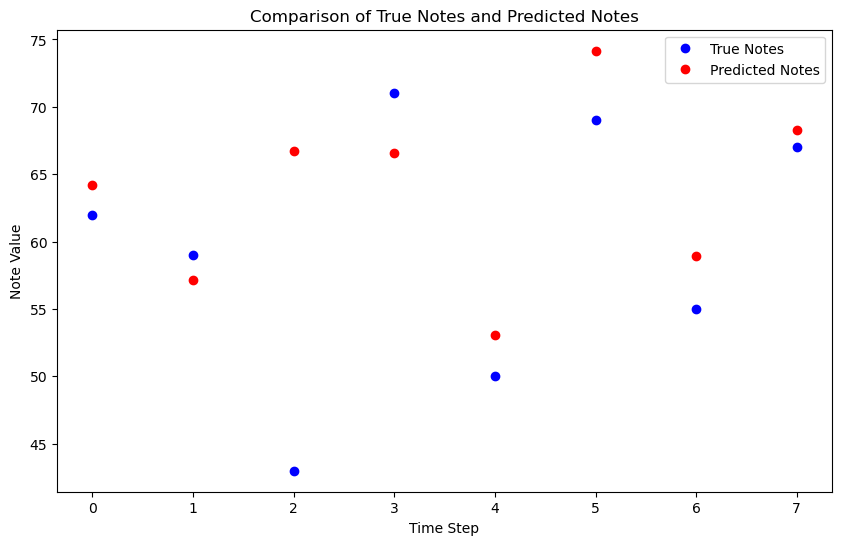

In [8]:
import matplotlib.pyplot as plt

# Predict the first sequence in the validation set
val_sequence = X_val[0]
val_sequence = np.expand_dims(val_sequence, axis=0)
predicted_output = model.predict(val_sequence)

# Extract the note values from the target and predicted sequences
true_notes = y_val[0][:, 0]
predicted_notes = predicted_output[0][:, 0]

# Plot the target notes and predicted notes
plt.figure(figsize=(10, 6))
plt.plot(true_notes, 'bo', label='True Notes')
plt.plot(predicted_notes, 'ro', label='Predicted Notes')
plt.xlabel('Time Step')
plt.ylabel('Note Value')
plt.title('Comparison of True Notes and Predicted Notes')
plt.legend()
plt.show()


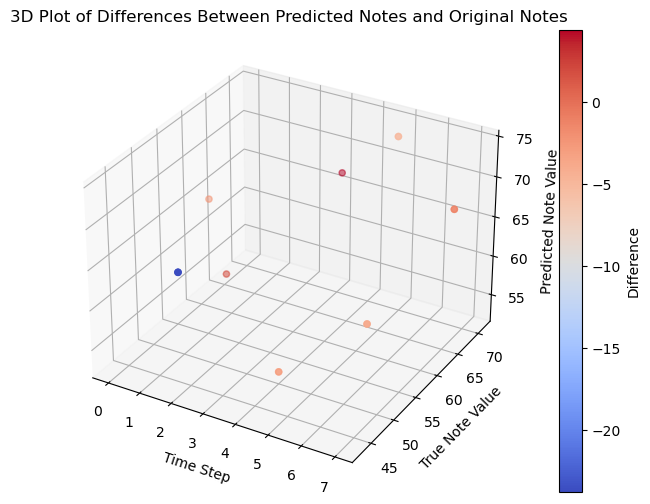

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate the differences between true and predicted notes
diff_notes = true_notes - predicted_notes

# Create the x, y, and z values for the 3D plot
x = np.arange(len(true_notes))
y = true_notes
z = predicted_notes

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=diff_notes, marker='o', cmap='coolwarm')

ax.set_xlabel('Time Step')
ax.set_ylabel('True Note Value')
ax.set_zlabel('Predicted Note Value')
ax.set_title('3D Plot of Differences Between Predicted Notes and Original Notes')

# Add a colorbar to represent the differences
cbar = plt.colorbar(ax.scatter(x, y, z, c=diff_notes, marker='o', cmap='coolwarm'))
cbar.set_label('Difference')

plt.show()
